In [ ]:
"""
JUDICIAL CASE DELAY PREDICTION PROJECT
Notebook 1: PDF Text Extraction & Data Processing
Platform: Google Colab
"""

# ============================================================================
# STEP 1: INSTALL REQUIRED PACKAGES
# ============================================================================

!pip install pdfplumber pytesseract pdf2image pillow pandas numpy tqdm -q
!apt-get install tesseract-ocr -y -q
!apt-get install poppler-utils -y -q

print("✅ All packages installed successfully!")

# ============================================================================
# STEP 2: IMPORT LIBRARIES
# ============================================================================

import os
import re
import pdfplumber
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

# ============================================================================
# STEP 3: MOUNT GOOGLE DRIVE (Upload your dataset here)
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

# Set your dataset path here
DATASET_PATH = "/content/drive/MyDrive/supreme_court_judgments"  # Change this to your path
OUTPUT_CSV_PATH = "/content/drive/MyDrive/sc_judgments_data.csv"

print(f"✅ Google Drive mounted!")
print(f"📁 Dataset Path: {DATASET_PATH}")

# ============================================================================
# STEP 4: HELPER FUNCTIONS FOR TEXT EXTRACTION
# ============================================================================

def extract_date_from_text(text, pattern_type='judgment'):
    """Extract dates using multiple regex patterns"""

    # Common date patterns in Indian legal documents
    patterns = {
        'judgment': [
            r'DATED[:\s]+(\d{1,2})[.\-/](\d{1,2})[.\-/](\d{4})',
            r'Date[:\s]+(\d{1,2})[.\-/](\d{1,2})[.\-/](\d{4})',
            r'(\d{1,2})[.\-/](\d{1,2})[.\-/](\d{4})',
            r'(\d{1,2})\s+(January|February|March|April|May|June|July|August|September|October|November|December)[,\s]+(\d{4})',
        ],
        'filing': [
            r'[Ff]iled\s+on[:\s]+(\d{1,2})[.\-/](\d{1,2})[.\-/](\d{4})',
            r'[Pp]etition\s+filed[:\s]+(\d{1,2})[.\-/](\d{1,2})[.\-/](\d{4})',
        ]
    }

    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }

    for pattern in patterns.get(pattern_type, patterns['judgment']):
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            try:
                groups = match.groups()
                if len(groups) == 3:
                    if groups[1] in month_map:  # Month name format
                        day, month, year = int(groups[0]), month_map[groups[1]], int(groups[2])
                    else:  # Numeric format
                        day, month, year = int(groups[0]), int(groups[1]), int(groups[2])

                    # Validate date
                    if 1 <= day <= 31 and 1 <= month <= 12 and 1950 <= year <= 2025:
                        return datetime(year, month, day)
            except:
                continue

    return None


def extract_case_number(text):
    """Extract case number from text"""
    patterns = [
        r'(Civil Appeal No[.\s]+\d+\s+of\s+\d{4})',
        r'(Criminal Appeal No[.\s]+\d+\s+of\s+\d{4})',
        r'(Writ Petition[s]?\s+\(Civil\)\s+No[.\s]+\d+\s+of\s+\d{4})',
        r'(Special Leave Petition[s]?\s+\(Civil\)\s+No[.\s]+\d+\s+of\s+\d{4})',
        r'(C\.?A\.?\s+No[.\s]+\d+\s+of\s+\d{4})',
        r'(SLP[s]?\s+\(C\)\s+No[.\s]+\d+\s+of\s+\d{4})',
    ]

    for pattern in patterns:
        match = re.search(pattern, text[:2000], re.IGNORECASE)
        if match:
            return match.group(1).strip()

    return "Unknown"


def extract_case_type(text):
    """Determine case type from case number or text"""
    text_upper = text.upper()

    if 'CIVIL APPEAL' in text_upper or 'C.A.' in text_upper:
        return 'Civil Appeal'
    elif 'CRIMINAL APPEAL' in text_upper or 'CR.A.' in text_upper:
        return 'Criminal Appeal'
    elif 'WRIT PETITION' in text_upper or 'W.P.' in text_upper:
        return 'Writ Petition'
    elif 'SPECIAL LEAVE PETITION' in text_upper or 'SLP' in text_upper:
        return 'Special Leave Petition'
    elif 'TRANSFER PETITION' in text_upper:
        return 'Transfer Petition'
    else:
        return 'Other'


def extract_parties(text):
    """Extract petitioner and respondent names"""
    # Look for "Versus", "Vs.", "V/s" pattern
    patterns = [
        r'([A-Z][A-Za-z\s&.,()]+?)\s+(?:Versus|Vs\.?|V/s)\s+([A-Z][A-Za-z\s&.,()]+?)(?:\n|Date|DATED)',
    ]

    for pattern in patterns:
        match = re.search(pattern, text[:3000], re.MULTILINE)
        if match:
            petitioner = match.group(1).strip()
            respondent = match.group(2).strip()
            return petitioner[:100], respondent[:100]

    return "Unknown", "Unknown"


def extract_judges(text):
    """Extract judge names from the judgment"""
    # Look for judge names (usually appear with J. or CJI)
    judge_pattern = r'([A-Z][a-z]+(?:\s+[A-Z][a-z]+)*),?\s+(?:J\.|CJI)'
    judges = re.findall(judge_pattern, text[:2000])

    if judges:
        return ', '.join(list(set(judges))[:5])  # Max 5 judges
    return "Unknown"


def count_citations(text):
    """Count number of case citations"""
    # Look for patterns like "2020 SCC 123", "AIR 1950 SC 14"
    citation_patterns = [
        r'\d{4}\s+SCC\s+\d+',
        r'AIR\s+\d{4}\s+SC\s+\d+',
        r'\[\d{4}\]\s+\d+\s+SCC\s+\d+',
    ]

    total_citations = 0
    for pattern in citation_patterns:
        total_citations += len(re.findall(pattern, text))

    return total_citations


def extract_acts_cited(text):
    """Count number of Acts/Statutes cited"""
    act_pattern = r'(?:The\s+)?[A-Z][A-Za-z\s,]+Act,?\s+\d{4}'
    acts = re.findall(act_pattern, text)
    return len(set(acts))


def determine_legal_domain(text):
    """Classify legal domain based on keywords"""
    text_lower = text.lower()

    domains = {
        'Criminal': ['criminal', 'murder', 'theft', 'fraud', 'accused', 'conviction', 'sentence'],
        'Civil': ['contract', 'damages', 'property', 'suit', 'plaintiff', 'defendant'],
        'Constitutional': ['article', 'constitution', 'fundamental rights', 'writ', 'habeas corpus'],
        'Tax': ['income tax', 'sales tax', 'gst', 'customs', 'excise'],
        'Labor': ['labor', 'labour', 'employment', 'industrial dispute', 'workmen'],
        'Family': ['divorce', 'custody', 'matrimonial', 'maintenance', 'marriage'],
        'Property': ['land', 'property', 'title', 'possession', 'real estate'],
    }

    scores = {}
    for domain, keywords in domains.items():
        scores[domain] = sum(text_lower.count(kw) for kw in keywords)

    if max(scores.values()) > 0:
        return max(scores, key=scores.get)
    return 'Other'


# ============================================================================
# STEP 5: MAIN EXTRACTION FUNCTION
# ============================================================================

def extract_judgment_data(pdf_path, year_folder):
    """Extract all relevant information from a single PDF"""

    try:
        data = {
            'file_name': os.path.basename(pdf_path),
            'year_folder': year_folder,
            'file_path': pdf_path
        }

        # Extract PDF content
        with pdfplumber.open(pdf_path) as pdf:
            # Get first 3 pages for metadata
            first_pages_text = ""
            for i in range(min(3, len(pdf.pages))):
                first_pages_text += pdf.pages[i].extract_text() or ""

            # Get full text for analysis
            full_text = ""
            for page in pdf.pages:
                full_text += page.extract_text() or ""

            # Basic metrics
            data['page_count'] = len(pdf.pages)
            data['word_count'] = len(full_text.split())

        # Extract key information
        data['case_number'] = extract_case_number(first_pages_text)
        data['case_type'] = extract_case_type(first_pages_text)

        # Extract dates
        judgment_date = extract_date_from_text(first_pages_text, 'judgment')
        filing_date = extract_date_from_text(full_text, 'filing')

        data['judgment_date'] = judgment_date.strftime('%Y-%m-%d') if judgment_date else None
        data['filing_date'] = filing_date.strftime('%Y-%m-%d') if filing_date else None

        # Calculate case duration
        if judgment_date and filing_date and judgment_date >= filing_date:
            data['case_duration_days'] = (judgment_date - filing_date).days
        else:
            data['case_duration_days'] = None

        # Extract parties and judges
        petitioner, respondent = extract_parties(first_pages_text)
        data['petitioner'] = petitioner
        data['respondent'] = respondent
        data['judges'] = extract_judges(first_pages_text)

        # Count judges (bench size)
        judge_list = data['judges'].split(',') if data['judges'] != 'Unknown' else []
        data['bench_size'] = len(judge_list) if judge_list else 1

        # Legal analysis
        data['citations_count'] = count_citations(full_text)
        data['acts_cited_count'] = extract_acts_cited(full_text)
        data['legal_domain'] = determine_legal_domain(full_text)

        # Extract year from judgment date or folder
        if judgment_date:
            data['judgment_year'] = judgment_date.year
        else:
            data['judgment_year'] = int(year_folder) if year_folder.isdigit() else None

        return data

    except Exception as e:
        print(f"❌ Error processing {pdf_path}: {str(e)}")
        return None


# ============================================================================
# STEP 6: BATCH PROCESSING FUNCTION
# ============================================================================

def process_all_judgments(dataset_path, sample_size=None):
    """Process all PDFs in the dataset"""

    all_data = []
    total_processed = 0
    total_errors = 0

    # Get all year folders
    year_folders = sorted([f for f in os.listdir(dataset_path)
                          if os.path.isdir(os.path.join(dataset_path, f))])

    print(f"📁 Found {len(year_folders)} year folders")
    print(f"🔍 Starting extraction...\n")

    for year_folder in tqdm(year_folders, desc="Processing years"):
        year_path = os.path.join(dataset_path, year_folder)

        # Get all PDFs in this year
        pdf_files = [f for f in os.listdir(year_path) if f.lower().endswith('.pdf')]

        # Sample if needed (for testing)
        if sample_size and len(pdf_files) > sample_size:
            pdf_files = pdf_files[:sample_size]

        print(f"📄 Year {year_folder}: Processing {len(pdf_files)} PDFs...")

        for pdf_file in pdf_files:
            pdf_path = os.path.join(year_path, pdf_file)

            # Extract data
            judgment_data = extract_judgment_data(pdf_path, year_folder)

            if judgment_data:
                all_data.append(judgment_data)
                total_processed += 1
            else:
                total_errors += 1

            # Progress update every 100 files
            if total_processed % 100 == 0:
                print(f"✅ Processed: {total_processed} | ❌ Errors: {total_errors}")

    print(f"\n🎉 Extraction Complete!")
    print(f"✅ Successfully processed: {total_processed}")
    print(f"❌ Errors: {total_errors}")

    return pd.DataFrame(all_data)


# ============================================================================
# STEP 7: RUN EXTRACTION
# ============================================================================

# FOR TESTING: Process sample (remove sample_size=5 for full dataset)
print("🚀 Starting PDF extraction...")
print("⚠️  NOTE: Processing full dataset will take several hours!")
print("💡 TIP: Start with sample_size=100 for testing\n")

# OPTION 1: Test with sample
df = process_all_judgments(DATASET_PATH, sample_size=5)  # Test with 5 PDFs per year

# OPTION 2: Process full dataset (uncomment below, comment above)
# df = process_all_judgments(DATASET_PATH)

# ============================================================================
# STEP 8: SAVE EXTRACTED DATA
# ============================================================================

print(f"\n📊 Extracted {len(df)} records")
print("\n🔍 Data Preview:")
print(df.head())

print("\n📈 Data Info:")
print(df.info())

# Save to CSV
df.to_csv(OUTPUT_CSV_PATH, index=False)
print(f"\n✅ Data saved to: {OUTPUT_CSV_PATH}")

# ============================================================================
# STEP 9: BASIC STATISTICS
# ============================================================================

print("\n" + "="*60)
print("📊 EXTRACTION STATISTICS")
print("="*60)

print(f"\nTotal Records: {len(df)}")
print(f"Date Range: {df['judgment_year'].min()} - {df['judgment_year'].max()}")
print(f"\nRecords with valid dates: {df['judgment_date'].notna().sum()}")
print(f"Records with case duration: {df['case_duration_days'].notna().sum()}")

print("\n📋 Case Types Distribution:")
print(df['case_type'].value_counts())

print("\n⚖️ Legal Domains Distribution:")
print(df['legal_domain'].value_counts())

print("\n⏱️ Case Duration Statistics (days):")
print(df['case_duration_days'].describe())

print("\n✅ Notebook 1 Complete! Proceed to Notebook 2 for Feature Engineering")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 106.0 MB/s eta 0:00:00
Reading package lists...
Building dependency tree...
Reading state information...
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.

Processing years:   1%|▏         | 1/76 [00:00<00:10,  7.43it/s]

📄 Year 1950: Processing 0 PDFs...


Processing years:   3%|▎         | 2/76 [00:00<00:10,  7.14it/s]

📄 Year 1951: Processing 0 PDFs...
📄 Year 1952: Processing 0 PDFs...
📄 Year 1953: Processing 0 PDFs...


Processing years:   7%|▋         | 5/76 [00:00<00:04, 14.45it/s]

📄 Year 1954: Processing 0 PDFs...
📄 Year 1955: Processing 0 PDFs...
📄 Year 1956: Processing 5 PDFs...


Processing years:   9%|▉         | 7/76 [00:07<01:48,  1.58s/it]

📄 Year 1957: Processing 5 PDFs...


Processing years:  11%|█         | 8/76 [00:20<04:37,  4.08s/it]

📄 Year 1958: Processing 0 PDFs...
📄 Year 1959: Processing 5 PDFs...


Processing years:  13%|█▎        | 10/76 [00:36<06:05,  5.54s/it]

📄 Year 1960: Processing 5 PDFs...


Processing years:  14%|█▍        | 11/76 [00:53<08:49,  8.15s/it]

📄 Year 1961: Processing 5 PDFs...


Processing years:  16%|█▌        | 12/76 [01:07<10:12,  9.57s/it]

📄 Year 1962: Processing 5 PDFs...


Processing years:  17%|█▋        | 13/76 [01:20<10:50, 10.32s/it]

📄 Year 1963: Processing 0 PDFs...
📄 Year 1964: Processing 5 PDFs...


Processing years:  20%|█▉        | 15/76 [01:27<07:37,  7.50s/it]

📄 Year 1965: Processing 0 PDFs...
📄 Year 1966: Processing 5 PDFs...


Processing years:  22%|██▏       | 17/76 [01:38<06:35,  6.70s/it]

📄 Year 1967: Processing 5 PDFs...


Processing years:  24%|██▎       | 18/76 [01:48<07:06,  7.35s/it]

📄 Year 1968: Processing 5 PDFs...


Processing years:  25%|██▌       | 19/76 [01:58<07:38,  8.04s/it]

📄 Year 1969: Processing 5 PDFs...


Processing years:  26%|██▋       | 20/76 [02:07<07:47,  8.34s/it]

📄 Year 1970: Processing 5 PDFs...


Processing years:  28%|██▊       | 21/76 [02:19<08:31,  9.31s/it]

📄 Year 1971: Processing 5 PDFs...


Processing years:  29%|██▉       | 22/76 [02:33<09:20, 10.38s/it]

📄 Year 1972: Processing 5 PDFs...


Processing years:  30%|███       | 23/76 [02:44<09:31, 10.79s/it]

📄 Year 1973: Processing 5 PDFs...


Processing years:  32%|███▏      | 24/76 [03:00<10:36, 12.23s/it]

📄 Year 1974: Processing 5 PDFs...


Processing years:  33%|███▎      | 25/76 [03:14<10:39, 12.54s/it]

📄 Year 1975: Processing 5 PDFs...


Processing years:  34%|███▍      | 26/76 [03:28<10:49, 12.99s/it]

📄 Year 1976: Processing 5 PDFs...


Processing years:  36%|███▌      | 27/76 [04:04<16:19, 19.98s/it]

📄 Year 1977: Processing 5 PDFs...


Processing years:  37%|███▋      | 28/76 [04:17<14:19, 17.91s/it]

📄 Year 1978: Processing 5 PDFs...


Processing years:  38%|███▊      | 29/76 [04:30<12:52, 16.44s/it]

✅ Processed: 100 | ❌ Errors: 0
📄 Year 1979: Processing 5 PDFs...


Processing years:  39%|███▉      | 30/76 [04:43<11:47, 15.39s/it]

📄 Year 1980: Processing 5 PDFs...


Processing years:  41%|████      | 31/76 [04:54<10:25, 13.89s/it]

📄 Year 1981: Processing 5 PDFs...


Processing years:  42%|████▏     | 32/76 [05:11<11:02, 15.05s/it]

📄 Year 1982: Processing 5 PDFs...


Processing years:  43%|████▎     | 33/76 [05:19<09:14, 12.90s/it]

📄 Year 1983: Processing 5 PDFs...


Processing years:  45%|████▍     | 34/76 [05:30<08:31, 12.19s/it]

📄 Year 1984: Processing 5 PDFs...


Processing years:  46%|████▌     | 35/76 [05:45<08:52, 13.00s/it]

📄 Year 1985: Processing 5 PDFs...


Processing years:  47%|████▋     | 36/76 [05:57<08:35, 12.90s/it]

📄 Year 1986: Processing 5 PDFs...


Processing years:  49%|████▊     | 37/76 [06:08<08:02, 12.36s/it]

📄 Year 1987: Processing 5 PDFs...


Processing years:  50%|█████     | 38/76 [06:20<07:39, 12.08s/it]

📄 Year 1988: Processing 5 PDFs...


Processing years:  51%|█████▏    | 39/76 [06:49<10:38, 17.27s/it]

📄 Year 1989: Processing 5 PDFs...


Processing years:  53%|█████▎    | 40/76 [07:01<09:21, 15.59s/it]

📄 Year 1990: Processing 5 PDFs...


Processing years:  54%|█████▍    | 41/76 [07:16<08:56, 15.34s/it]

📄 Year 1991: Processing 5 PDFs...


Processing years:  55%|█████▌    | 42/76 [07:24<07:28, 13.18s/it]

📄 Year 1992: Processing 5 PDFs...


Processing years:  57%|█████▋    | 43/76 [07:38<07:23, 13.44s/it]

📄 Year 1993: Processing 5 PDFs...


Processing years:  58%|█████▊    | 44/76 [07:48<06:40, 12.52s/it]

📄 Year 1994: Processing 5 PDFs...


Processing years:  59%|█████▉    | 45/76 [08:02<06:39, 12.89s/it]

📄 Year 1995: Processing 5 PDFs...


Processing years:  61%|██████    | 46/76 [08:15<06:29, 12.97s/it]

📄 Year 1996: Processing 5 PDFs...


Processing years:  62%|██████▏   | 47/76 [08:28<06:16, 12.99s/it]

📄 Year 1997: Processing 5 PDFs...


Processing years:  63%|██████▎   | 48/76 [08:40<05:58, 12.79s/it]

📄 Year 1998: Processing 5 PDFs...


Processing years:  64%|██████▍   | 49/76 [08:52<05:38, 12.52s/it]

✅ Processed: 200 | ❌ Errors: 0
📄 Year 1999: Processing 5 PDFs...


Processing years:  66%|██████▌   | 50/76 [09:04<05:20, 12.33s/it]

📄 Year 2000: Processing 5 PDFs...


Processing years:  67%|██████▋   | 51/76 [09:15<04:54, 11.78s/it]

📄 Year 2001: Processing 5 PDFs...


Processing years:  68%|██████▊   | 52/76 [09:24<04:27, 11.17s/it]

📄 Year 2002: Processing 5 PDFs...


Processing years:  70%|██████▉   | 53/76 [09:36<04:22, 11.43s/it]

📄 Year 2003: Processing 5 PDFs...


Processing years:  71%|███████   | 54/76 [09:55<04:55, 13.41s/it]

📄 Year 2004: Processing 5 PDFs...


Processing years:  72%|███████▏  | 55/76 [10:06<04:27, 12.72s/it]

📄 Year 2005: Processing 5 PDFs...


Processing years:  74%|███████▎  | 56/76 [10:19<04:17, 12.86s/it]

📄 Year 2006: Processing 5 PDFs...


Processing years:  75%|███████▌  | 57/76 [10:36<04:27, 14.06s/it]

📄 Year 2007: Processing 5 PDFs...


Processing years:  76%|███████▋  | 58/76 [10:46<03:55, 13.08s/it]

📄 Year 2008: Processing 5 PDFs...


Processing years:  78%|███████▊  | 59/76 [11:28<06:08, 21.66s/it]

📄 Year 2009: Processing 5 PDFs...


Processing years:  79%|███████▉  | 60/76 [11:39<04:56, 18.52s/it]

📄 Year 2010: Processing 5 PDFs...


Processing years:  80%|████████  | 61/76 [11:55<04:23, 17.58s/it]

📄 Year 2011: Processing 5 PDFs...


Processing years:  82%|████████▏ | 62/76 [12:09<03:51, 16.54s/it]

📄 Year 2012: Processing 5 PDFs...


Processing years:  83%|████████▎ | 63/76 [12:29<03:50, 17.70s/it]

📄 Year 2013: Processing 5 PDFs...


Processing years:  84%|████████▍ | 64/76 [12:44<03:23, 16.93s/it]

📄 Year 2014: Processing 5 PDFs...


Processing years:  86%|████████▌ | 65/76 [12:56<02:48, 15.33s/it]

📄 Year 2015: Processing 5 PDFs...


Processing years:  87%|████████▋ | 66/76 [13:14<02:40, 16.04s/it]

📄 Year 2016: Processing 5 PDFs...


Processing years:  88%|████████▊ | 67/76 [13:28<02:20, 15.61s/it]

📄 Year 2017: Processing 5 PDFs...


Processing years:  89%|████████▉ | 68/76 [13:46<02:10, 16.26s/it]

📄 Year 2018: Processing 5 PDFs...


Processing years:  91%|█████████ | 69/76 [13:59<01:47, 15.31s/it]

✅ Processed: 300 | ❌ Errors: 0
📄 Year 2019: Processing 5 PDFs...


Processing years:  92%|█████████▏| 70/76 [14:14<01:31, 15.22s/it]

📄 Year 2020: Processing 5 PDFs...


Processing years:  93%|█████████▎| 71/76 [14:32<01:20, 16.08s/it]

📄 Year 2021: Processing 5 PDFs...


Processing years:  95%|█████████▍| 72/76 [14:46<01:01, 15.41s/it]

📄 Year 2022: Processing 5 PDFs...


Processing years:  96%|█████████▌| 73/76 [15:01<00:46, 15.35s/it]

📄 Year 2023: Processing 5 PDFs...


Processing years:  97%|█████████▋| 74/76 [15:28<00:37, 18.69s/it]

📄 Year 2024: Processing 5 PDFs...


Processing years:  99%|█████████▊| 75/76 [15:53<00:20, 20.75s/it]

📄 Year 2025: Processing 5 PDFs...


Processing years: 100%|██████████| 76/76 [16:10<00:00, 12.77s/it]



🎉 Extraction Complete!
✅ Successfully processed: 335
❌ Errors: 0

📊 Extracted 335 records

🔍 Data Preview:
                                           file_name year_folder  \
0  Baroda_Borough_Municipality_vs_Its_Workmen_on_...        1956   
1  Dwarka_Dass_Bhatia_vs_The_State_Of_Jammu_And_K...        1956   
2  Keshav_Nilkanth_Joglekar_vs_The_Commissioner_O...        1956   
3  Management_Of_All_Tea_Estates_In_Assam_vs_Indi...        1956   
4  Govt_Of_State_Of_Bihar_Ors_vs_Ram_Bharosa_Sing...        1956   

                                           file_path  page_count  word_count  \
0  /content/drive/MyDrive/supreme_court_judgments...          12        6729   
1  /content/drive/MyDrive/supreme_court_judgments...           7        3084   
2  /content/drive/MyDrive/supreme_court_judgments...           7        3554   
3  /content/drive/MyDrive/supreme_court_judgments...           5        2993   
4  /content/drive/MyDrive/supreme_court_judgments...           3        1251   

  

✅ Libraries imported successfully!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded 335 records

🔍 Initial Data Shape: (335, 18)
                                           file_name  year_folder  \
0  Baroda_Borough_Municipality_vs_Its_Workmen_on_...         1956   
1  Dwarka_Dass_Bhatia_vs_The_State_Of_Jammu_And_K...         1956   
2  Keshav_Nilkanth_Joglekar_vs_The_Commissioner_O...         1956   
3  Management_Of_All_Tea_Estates_In_Assam_vs_Indi...         1956   
4  Govt_Of_State_Of_Bihar_Ors_vs_Ram_Bharosa_Sing...         1956   

                                           file_path  page_count  word_count  \
0  /content/drive/MyDrive/supreme_court_judgments...          12        6729   
1  /content/drive/MyDrive/supreme_court_judgments...           7        3084   
2  /content/drive/MyDrive/supreme_court_judgments...           7        3554   
3  /content/drive/MyDrive/supreme_court_judgmen

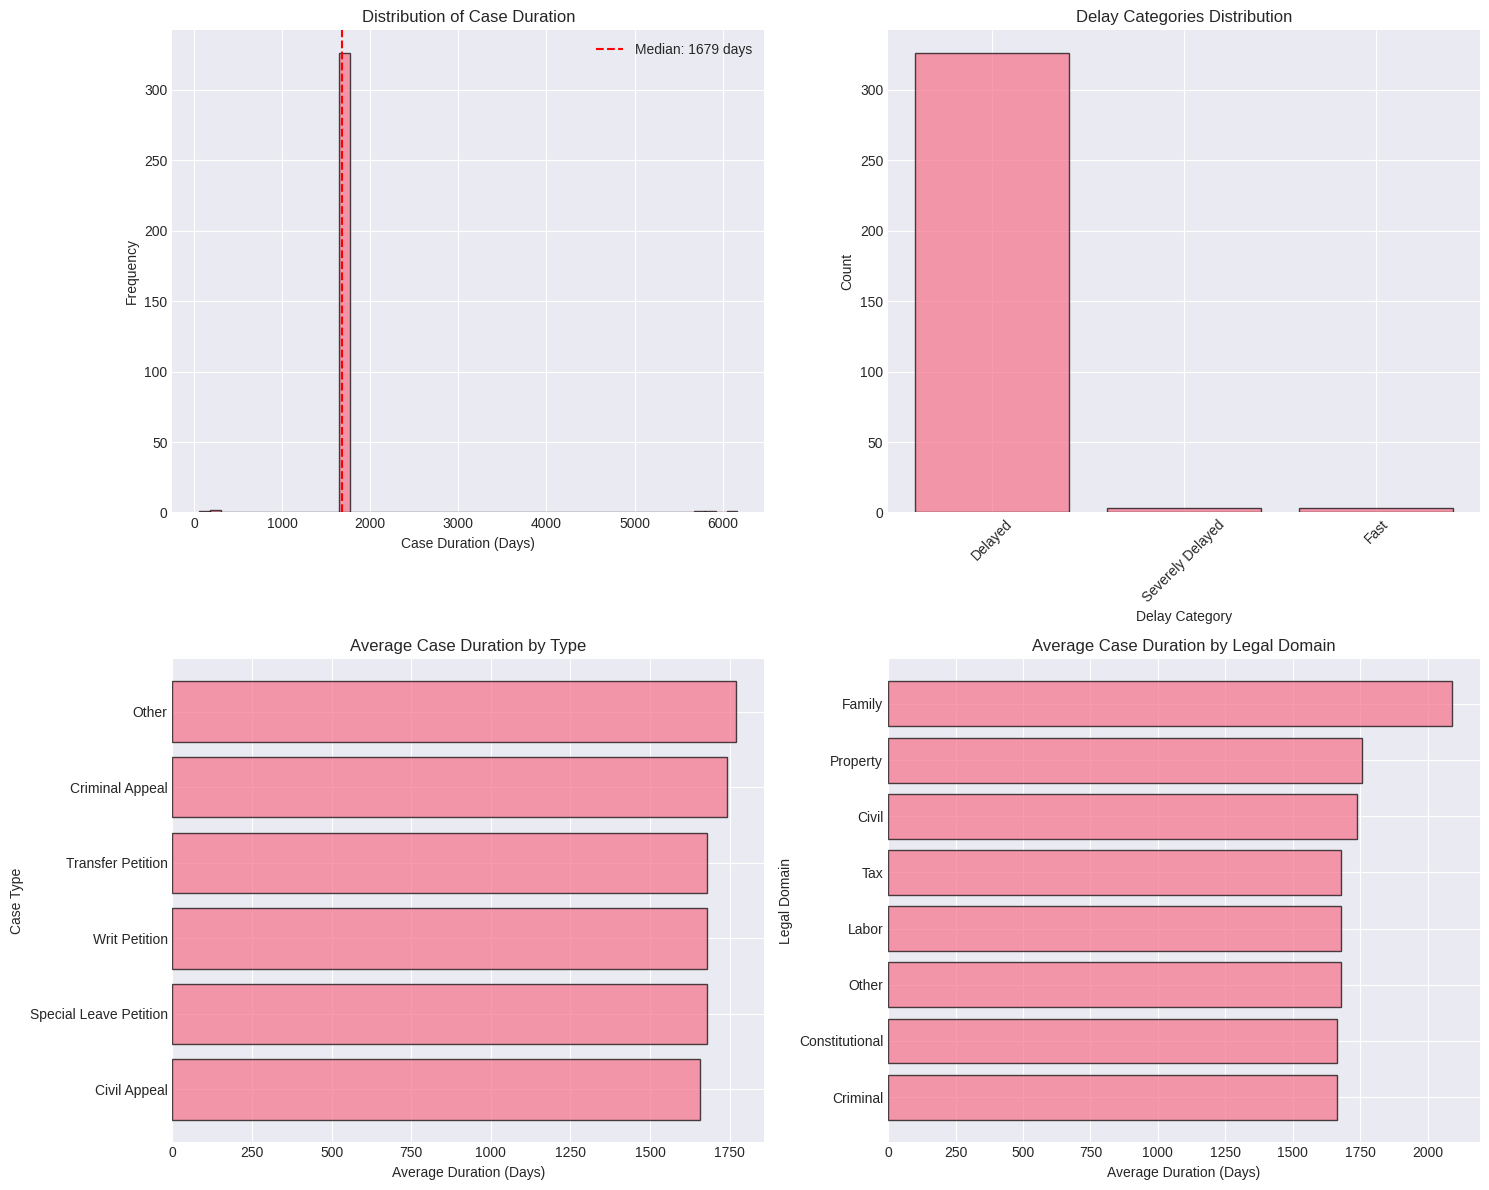

✅ Visualization 1 saved


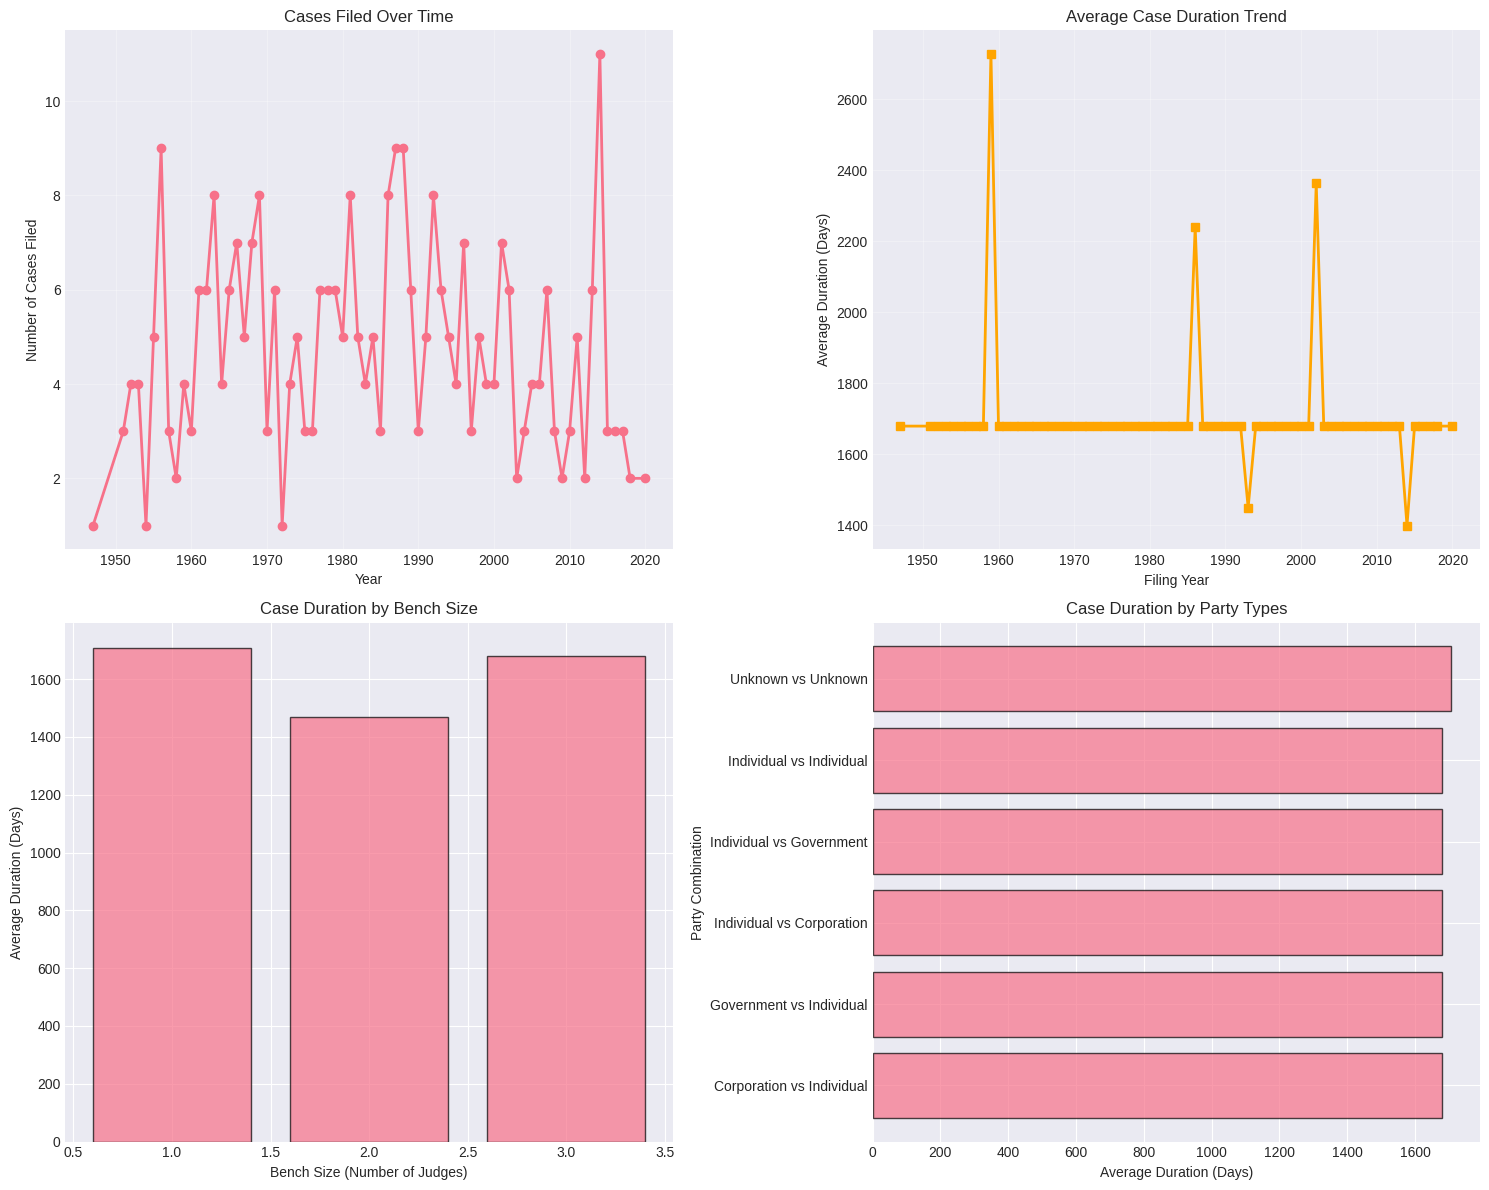

✅ Visualization 2 saved


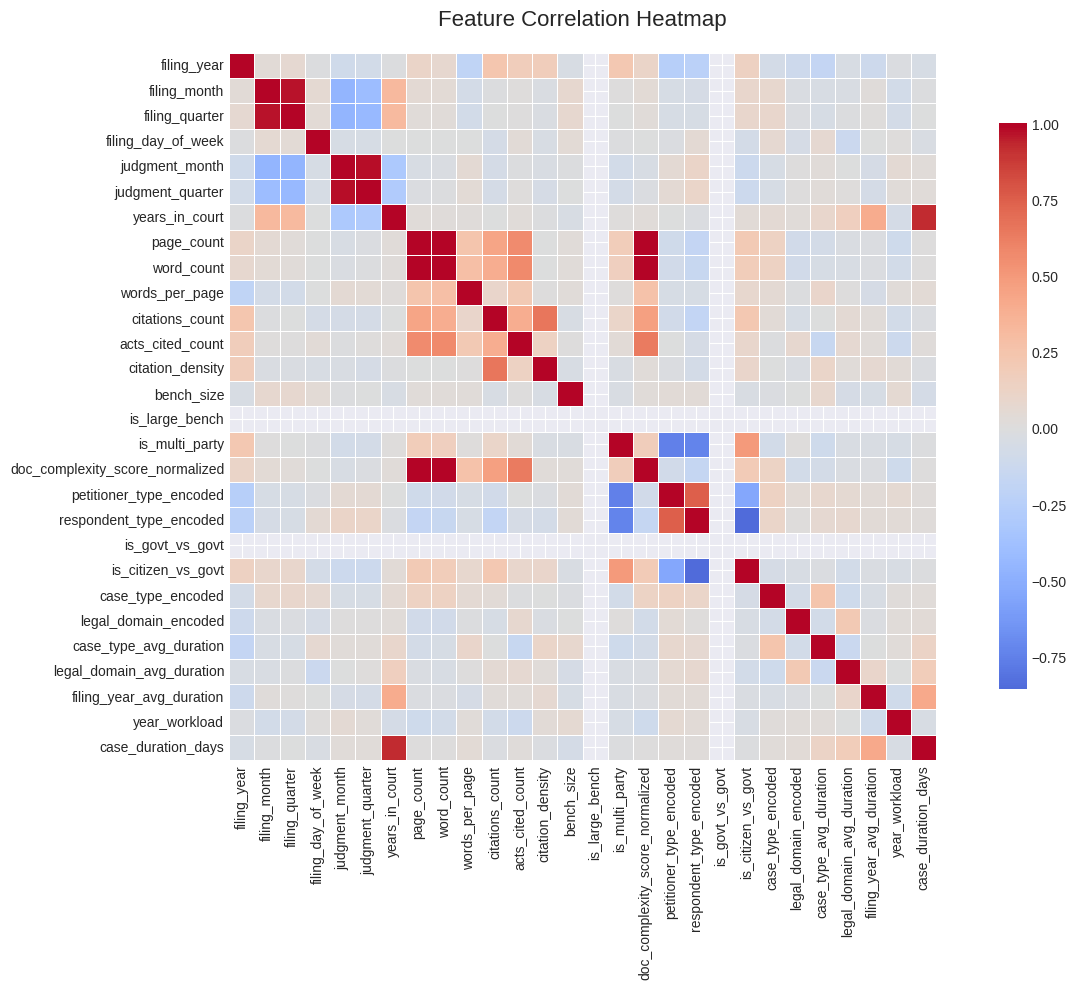

✅ Visualization 3 saved

💾 SAVING PROCESSED DATA
✅ Processed data saved to: /content/drive/MyDrive/sc_judgments_processed.csv
✅ Feature list saved

📊 FINAL DATA SUMMARY

Total Records: 332
Total Features: 27

Date Range: 1947 - 2025

📈 Case Duration Statistics:
  Mean: 1704.08 days
  Median: 1679.00 days
  Std Dev: 429.37 days
  Min: 60.00 days
  Max: 6167.00 days

⚖️ Delay Categories:
  Delayed: 326 (98.2%)
  Severely Delayed: 3 (0.9%)
  Fast: 3 (0.9%)

📋 Top 5 Case Types:
case_type
Civil Appeal              135
Other                      95
Writ Petition              53
Criminal Appeal            43
Special Leave Petition      4
Name: count, dtype: int64

⚖️ Top 5 Legal Domains:
legal_domain
Constitutional    97
Criminal          81
Property          53
Civil             48
Labor             21
Name: count, dtype: int64

✅ Feature Engineering Complete!
🚀 Proceed to Notebook 3 for Model Training

📊 Train/Test Split:
  Training set: 265 records
  Test set: 67 records
✅ Train/Test data 

In [ ]:
"""
JUDICIAL CASE DELAY PREDICTION PROJECT
Notebook 2: Feature Engineering & Data Preparation
Platform: Google Colab
"""

# ============================================================================
# STEP 1: IMPORT LIBRARIES
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

# ============================================================================
# STEP 2: MOUNT DRIVE & LOAD DATA
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

# Load the extracted data from Notebook 1
INPUT_CSV_PATH = "/content/drive/MyDrive/sc_judgments_data.csv"
OUTPUT_PROCESSED_PATH = "/content/drive/MyDrive/sc_judgments_processed.csv"

df = pd.read_csv(INPUT_CSV_PATH)
print(f"✅ Loaded {len(df)} records")
print(f"\n🔍 Initial Data Shape: {df.shape}")
print(df.head())

# ============================================================================
# STEP 3: DATA CLEANING
# ============================================================================

print("\n" + "="*60)
print("🧹 DATA CLEANING")
print("="*60)

# Convert date columns to datetime
df['judgment_date'] = pd.to_datetime(df['judgment_date'], errors='coerce')
df['filing_date'] = pd.to_datetime(df['filing_date'], errors='coerce')

# Remove records without judgment date (essential for delay calculation)
initial_count = len(df)
df = df[df['judgment_date'].notna()].copy()
print(f"✅ Removed {initial_count - len(df)} records without judgment date")

# For records without filing date, estimate based on typical patterns
# Assumption: If no filing date, use judgment_date - median duration
median_duration = df['case_duration_days'].median()
df.loc[df['filing_date'].isna(), 'filing_date'] = df.loc[df['filing_date'].isna(), 'judgment_date'] - pd.Timedelta(days=median_duration)

# Recalculate case duration for imputed dates
df['case_duration_days'] = (df['judgment_date'] - df['filing_date']).dt.days

# Remove impossible durations (negative or extremely high)
df = df[(df['case_duration_days'] >= 0) & (df['case_duration_days'] <= 20000)].copy()
print(f"✅ Cleaned duration data: {len(df)} records remaining")

# Fill missing values in categorical columns
df['case_type'] = df['case_type'].fillna('Other')
df['legal_domain'] = df['legal_domain'].fillna('Other')
df['judges'] = df['judges'].fillna('Unknown')

# Fill missing numeric values
df['bench_size'] = df['bench_size'].fillna(1)
df['citations_count'] = df['citations_count'].fillna(0)
df['acts_cited_count'] = df['acts_cited_count'].fillna(0)
df['page_count'] = df['page_count'].fillna(df['page_count'].median())
df['word_count'] = df['word_count'].fillna(df['word_count'].median())

print("✅ Missing values handled")

# ============================================================================
# STEP 4: FEATURE ENGINEERING
# ============================================================================

print("\n" + "="*60)
print("🔧 FEATURE ENGINEERING")
print("="*60)

# -------------------- TEMPORAL FEATURES --------------------

df['filing_year'] = df['filing_date'].dt.year
df['filing_month'] = df['filing_date'].dt.month
df['filing_quarter'] = df['filing_date'].dt.quarter
df['filing_day_of_week'] = df['filing_date'].dt.dayofweek
df['filing_day_of_year'] = df['filing_date'].dt.dayofyear

df['judgment_month'] = df['judgment_date'].dt.month
df['judgment_quarter'] = df['judgment_date'].dt.quarter

# Years in court (from filing year to judgment year)
df['years_in_court'] = df['judgment_year'] - df['filing_year']

print("✅ Created temporal features")

# -------------------- COMPLEXITY FEATURES --------------------

# Document complexity score
df['doc_complexity_score'] = (
    df['page_count'] * 0.3 +
    df['word_count'] / 1000 * 0.3 +
    df['citations_count'] * 0.2 +
    df['acts_cited_count'] * 0.2
)

# Normalize complexity score
df['doc_complexity_score_normalized'] = (
    (df['doc_complexity_score'] - df['doc_complexity_score'].min()) /
    (df['doc_complexity_score'].max() - df['doc_complexity_score'].min())
)

# Words per page (writing density)
df['words_per_page'] = df['word_count'] / df['page_count'].replace(0, 1)

# Citation density
df['citation_density'] = df['citations_count'] / df['page_count'].replace(0, 1)

# Multi-party indicator (crude check based on petitioner/respondent names)
df['is_multi_party'] = df.apply(
    lambda x: 1 if ('&' in str(x['petitioner']) or '&' in str(x['respondent'])) else 0,
    axis=1
)

# Large bench indicator (constitutional bench typically 5+ judges)
df['is_large_bench'] = (df['bench_size'] >= 5).astype(int)

print("✅ Created complexity features")

# -------------------- PARTY TYPE FEATURES --------------------

def classify_party_type(party_name):
    """Classify party as Government, Corporation, or Individual"""
    if pd.isna(party_name) or party_name == 'Unknown':
        return 'Unknown'

    party_upper = str(party_name).upper()

    # Government entities
    gov_keywords = ['UNION OF INDIA', 'STATE OF', 'GOVERNMENT', 'MINISTRY',
                    'DEPARTMENT', 'COMMISSIONER', 'COLLECTOR', 'SECRETARY']
    if any(kw in party_upper for kw in gov_keywords):
        return 'Government'

    # Corporations
    corp_keywords = ['LTD', 'LIMITED', 'PVT', 'PRIVATE', 'CORPORATION',
                     'COMPANY', 'BANK', 'INDUSTRIES', 'INC']
    if any(kw in party_upper for kw in corp_keywords):
        return 'Corporation'

    return 'Individual'

df['petitioner_type'] = df['petitioner'].apply(classify_party_type)
df['respondent_type'] = df['respondent'].apply(classify_party_type)

# Government vs Government cases (often take longer)
df['is_govt_vs_govt'] = (
    (df['petitioner_type'] == 'Government') &
    (df['respondent_type'] == 'Government')
).astype(int)

# Citizen vs Government cases
df['is_citizen_vs_govt'] = (
    ((df['petitioner_type'] == 'Individual') & (df['respondent_type'] == 'Government')) |
    ((df['petitioner_type'] == 'Government') & (df['respondent_type'] == 'Individual'))
).astype(int)

print("✅ Created party type features")

# -------------------- HISTORICAL AGGREGATE FEATURES --------------------

# Average duration by case type
case_type_avg = df.groupby('case_type')['case_duration_days'].transform('mean')
df['case_type_avg_duration'] = case_type_avg

# Average duration by legal domain
domain_avg = df.groupby('legal_domain')['case_duration_days'].transform('mean')
df['legal_domain_avg_duration'] = domain_avg

# Average duration by year (temporal trend)
year_avg = df.groupby('filing_year')['case_duration_days'].transform('mean')
df['filing_year_avg_duration'] = year_avg

# Workload per year (cases filed that year)
year_workload = df.groupby('filing_year')['case_number'].transform('count')
df['year_workload'] = year_workload

print("✅ Created historical aggregate features")

# -------------------- TARGET VARIABLE ENGINEERING --------------------

# Create delay categories for classification
def categorize_delay(days):
    if days <= 365:
        return 0  # Fast (<=1 year)
    elif days <= 730:
        return 1  # Normal (1-2 years)
    elif days <= 1825:
        return 2  # Delayed (2-5 years)
    else:
        return 3  # Severely Delayed (>5 years)

df['delay_category'] = df['case_duration_days'].apply(categorize_delay)
df['delay_category_name'] = df['delay_category'].map({
    0: 'Fast', 1: 'Normal', 2: 'Delayed', 3: 'Severely Delayed'
})

# Binary classification: Delayed or Not
df['is_delayed'] = (df['case_duration_days'] > 730).astype(int)

print("✅ Created target variables")

# ============================================================================
# STEP 5: ENCODE CATEGORICAL VARIABLES
# ============================================================================

print("\n" + "="*60)
print("🔢 ENCODING CATEGORICAL VARIABLES")
print("="*60)

# Label encoding for categorical variables
label_encoders = {}

categorical_cols = ['case_type', 'legal_domain', 'petitioner_type', 'respondent_type']

for col in categorical_cols:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"✅ Encoded {col}")

# ============================================================================
# STEP 6: FEATURE SELECTION
# ============================================================================

print("\n" + "="*60)
print("📋 FEATURE SELECTION")
print("="*60)

# Define feature sets for modeling
feature_columns = [
    # Temporal features
    'filing_year', 'filing_month', 'filing_quarter', 'filing_day_of_week',
    'judgment_month', 'judgment_quarter', 'years_in_court',

    # Complexity features
    'page_count', 'word_count', 'words_per_page',
    'citations_count', 'acts_cited_count', 'citation_density',
    'bench_size', 'is_large_bench', 'is_multi_party',
    'doc_complexity_score_normalized',

    # Party features
    'petitioner_type_encoded', 'respondent_type_encoded',
    'is_govt_vs_govt', 'is_citizen_vs_govt',

    # Encoded categorical features
    'case_type_encoded', 'legal_domain_encoded',

    # Historical features
    'case_type_avg_duration', 'legal_domain_avg_duration',
    'filing_year_avg_duration', 'year_workload',
]

# Target variables
target_regression = 'case_duration_days'
target_classification = 'delay_category'
target_binary = 'is_delayed'

print(f"✅ Selected {len(feature_columns)} features for modeling")
print(f"\nFeatures: {feature_columns}")

# ============================================================================
# STEP 7: DATA VISUALIZATION
# ============================================================================

print("\n" + "="*60)
print("📊 DATA VISUALIZATION")
print("="*60)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Figure 1: Case Duration Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution of case duration
axes[0, 0].hist(df['case_duration_days'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Case Duration (Days)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Case Duration')
axes[0, 0].axvline(df['case_duration_days'].median(), color='red',
                    linestyle='--', label=f'Median: {df["case_duration_days"].median():.0f} days')
axes[0, 0].legend()

# Delay categories distribution
delay_counts = df['delay_category_name'].value_counts()
axes[0, 1].bar(delay_counts.index, delay_counts.values, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Delay Category')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Delay Categories Distribution')
axes[0, 1].tick_params(axis='x', rotation=45)

# Case duration by case type
case_type_duration = df.groupby('case_type')['case_duration_days'].mean().sort_values()
axes[1, 0].barh(case_type_duration.index, case_type_duration.values, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Average Duration (Days)')
axes[1, 0].set_ylabel('Case Type')
axes[1, 0].set_title('Average Case Duration by Type')

# Case duration by legal domain
domain_duration = df.groupby('legal_domain')['case_duration_days'].mean().sort_values()
axes[1, 1].barh(domain_duration.index, domain_duration.values, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Average Duration (Days)')
axes[1, 1].set_ylabel('Legal Domain')
axes[1, 1].set_title('Average Case Duration by Legal Domain')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/case_duration_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization 1 saved")

# Figure 2: Temporal Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Cases filed per year
cases_per_year = df.groupby('filing_year').size()
axes[0, 0].plot(cases_per_year.index, cases_per_year.values, marker='o', linewidth=2)
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Cases Filed')
axes[0, 0].set_title('Cases Filed Over Time')
axes[0, 0].grid(True, alpha=0.3)

# Average duration over years
avg_duration_year = df.groupby('filing_year')['case_duration_days'].mean()
axes[0, 1].plot(avg_duration_year.index, avg_duration_year.values, marker='s',
                linewidth=2, color='orange')
axes[0, 1].set_xlabel('Filing Year')
axes[0, 1].set_ylabel('Average Duration (Days)')
axes[0, 1].set_title('Average Case Duration Trend')
axes[0, 1].grid(True, alpha=0.3)

# Duration by bench size
bench_duration = df.groupby('bench_size')['case_duration_days'].mean()
axes[1, 0].bar(bench_duration.index, bench_duration.values, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Bench Size (Number of Judges)')
axes[1, 0].set_ylabel('Average Duration (Days)')
axes[1, 0].set_title('Case Duration by Bench Size')

# Duration by party type
party_combinations = df.groupby(['petitioner_type', 'respondent_type'])['case_duration_days'].mean().sort_values()
axes[1, 1].barh([f"{idx[0]} vs {idx[1]}" for idx in party_combinations.index],
                party_combinations.values, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Average Duration (Days)')
axes[1, 1].set_ylabel('Party Combination')
axes[1, 1].set_title('Case Duration by Party Types')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/temporal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization 2 saved")

# Figure 3: Correlation Heatmap
fig, ax = plt.subplots(figsize=(14, 10))

# Select numeric features for correlation
numeric_features = [col for col in feature_columns if col in df.columns]
numeric_features.append('case_duration_days')

correlation_matrix = df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Feature Correlation Heatmap', fontsize=16, pad=20)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization 3 saved")

# ============================================================================
# STEP 8: SAVE PROCESSED DATA
# ============================================================================

print("\n" + "="*60)
print("💾 SAVING PROCESSED DATA")
print("="*60)

# Save the processed dataframe
df.to_csv(OUTPUT_PROCESSED_PATH, index=False)
print(f"✅ Processed data saved to: {OUTPUT_PROCESSED_PATH}")

# Save feature list for later use
feature_list_df = pd.DataFrame({
    'feature_name': feature_columns,
    'feature_type': ['numeric'] * len(feature_columns)
})
feature_list_df.to_csv('/content/drive/MyDrive/feature_list.csv', index=False)
print("✅ Feature list saved")

# ============================================================================
# STEP 9: DATA SUMMARY
# ============================================================================

print("\n" + "="*60)
print("📊 FINAL DATA SUMMARY")
print("="*60)

print(f"\nTotal Records: {len(df)}")
print(f"Total Features: {len(feature_columns)}")
print(f"\nDate Range: {df['filing_year'].min()} - {df['judgment_year'].max()}")

print(f"\n📈 Case Duration Statistics:")
print(f"  Mean: {df['case_duration_days'].mean():.2f} days")
print(f"  Median: {df['case_duration_days'].median():.2f} days")
print(f"  Std Dev: {df['case_duration_days'].std():.2f} days")
print(f"  Min: {df['case_duration_days'].min():.2f} days")
print(f"  Max: {df['case_duration_days'].max():.2f} days")

print(f"\n⚖️ Delay Categories:")
for category, count in df['delay_category_name'].value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"  {category}: {count} ({percentage:.1f}%)")

print(f"\n📋 Top 5 Case Types:")
print(df['case_type'].value_counts().head())

print(f"\n⚖️ Top 5 Legal Domains:")
print(df['legal_domain'].value_counts().head())

print(f"\n✅ Feature Engineering Complete!")
print("🚀 Proceed to Notebook 3 for Model Training")

# ============================================================================
# STEP 10: EXPORT TRAIN/TEST SPLIT DATA
# ============================================================================

from sklearn.model_selection import train_test_split

# Create train/test split (80/20)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42,
                                      stratify=df['delay_category'])

print(f"\n📊 Train/Test Split:")
print(f"  Training set: {len(train_df)} records")
print(f"  Test set: {len(test_df)} records")

# Save splits
train_df.to_csv('/content/drive/MyDrive/train_data.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/test_data.csv', index=False)

print("✅ Train/Test data saved")
print("\n" + "="*60)
print("✅ NOTEBOOK 2 COMPLETE!")
print("="*60)

In [ ]:
# """
# JUDICIAL CASE DELAY PREDICTION PROJECT
# Notebook 3: ML Model Training & Evaluation
# Platform: Google Colab
# """

# # ============================================================================
# # STEP 1: INSTALL & IMPORT LIBRARIES
# # ============================================================================

# !pip install xgboost lightgbm scikit-learn matplotlib seaborn shap -q

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pickle
# import warnings
# warnings.filterwarnings('ignore')

# # ML Libraries
# from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
#                              classification_report, confusion_matrix,
#                              accuracy_score, precision_recall_fscore_support)

# # Models
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
# from sklearn.tree import DecisionTreeRegressor
# from xgboost import XGBRegressor, XGBClassifier
# from lightgbm import LGBMRegressor, LGBMClassifier

# print("✅ All libraries imported successfully!")

# # ============================================================================
# # STEP 2: MOUNT DRIVE & LOAD DATA
# # ============================================================================

# from google.colab import drive
# drive.mount('/content/drive')

# # Load processed data
# TRAIN_PATH = "/content/drive/MyDrive/train_data.csv"
# TEST_PATH = "/content/drive/MyDrive/test_data.csv"
# FEATURE_LIST_PATH = "/content/drive/MyDrive/feature_list.csv"
# MODEL_SAVE_PATH = "/content/drive/MyDrive/models/"

# # Create model directory if it doesn't exist
# import os
# os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# # Load data
# train_df = pd.read_csv(TRAIN_PATH)
# test_df = pd.read_csv(TEST_PATH)
# feature_list = pd.read_csv(FEATURE_LIST_PATH)

# print(f"✅ Training data loaded: {train_df.shape}")
# print(f"✅ Test data loaded: {test_df.shape}")

# # ============================================================================
# # STEP 3: PREPARE DATA FOR MODELING
# # ============================================================================

# print("\n" + "="*60)
# print("🔧 PREPARING DATA FOR MODELING")
# print("="*60)

# # Get feature columns
# feature_columns = feature_list['feature_name'].tolist()

# # Prepare regression data (predicting case duration in days)
# X_train_reg = train_df[feature_columns].copy()
# y_train_reg = train_df['case_duration_days'].copy()

# X_test_reg = test_df[feature_columns].copy()
# y_test_reg = test_df['case_duration_days'].copy()

# # Prepare classification data (predicting delay category)
# X_train_clf = train_df[feature_columns].copy()
# y_train_clf = train_df['delay_category'].copy()

# X_test_clf = test_df[feature_columns].copy()
# y_test_clf = test_df['delay_category'].copy()

# print(f"✅ Regression data prepared: X_train {X_train_reg.shape}, y_train {y_train_reg.shape}")
# print(f"✅ Classification data prepared: X_train {X_train_clf.shape}, y_train {y_train_clf.shape}")

# # Handle any remaining NaN values
# X_train_reg = X_train_reg.fillna(X_train_reg.mean())
# X_test_reg = X_test_reg.fillna(X_train_reg.mean())
# X_train_clf = X_train_clf.fillna(X_train_clf.mean())
# X_test_clf = X_test_clf.fillna(X_train_clf.mean())

# # Scale features (important for some algorithms)
# scaler = StandardScaler()
# X_train_reg_scaled = scaler.fit_transform(X_train_reg)
# X_test_reg_scaled = scaler.transform(X_test_reg)

# X_train_clf_scaled = X_train_clf.values
# X_test_clf_scaled = X_test_clf.values

# print("✅ Data preprocessing complete")

# # ============================================================================
# # STEP 4: REGRESSION MODELS (Predicting Case Duration)
# # ============================================================================

# print("\n" + "="*60)
# print("📊 REGRESSION MODELS - PREDICTING CASE DURATION")
# print("="*60)

# regression_results = {}

# # -------------------- Model 1: Random Forest --------------------
# print("\n🌲 Training Random Forest Regressor...")
# rf_reg = RandomForestRegressor(
#     n_estimators=200,
#     max_depth=20,
#     min_samples_split=5,
#     min_samples_leaf=2,
#     random_state=42,
#     n_jobs=-1,
#     verbose=0
# )
# rf_reg.fit(X_train_reg, y_train_reg)
# rf_pred = rf_reg.predict(X_test_reg)

# rf_mae = mean_absolute_error(y_test_reg, rf_pred)
# rf_rmse = np.sqrt(mean_squared_error(y_test_reg, rf_pred))
# rf_r2 = r2_score(y_test_reg, rf_pred)

# regression_results['Random Forest'] = {
#     'model': rf_reg,
#     'predictions': rf_pred,
#     'MAE': rf_mae,
#     'RMSE': rf_rmse,
#     'R2': rf_r2
# }

# print(f"✅ Random Forest - MAE: {rf_mae:.2f} days, RMSE: {rf_rmse:.2f} days, R²: {rf_r2:.4f}")

# # -------------------- Model 2: XGBoost --------------------
# print("\n🚀 Training XGBoost Regressor...")
# xgb_reg = XGBRegressor(
#     n_estimators=200,
#     max_depth=10,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1,
#     verbosity=0
# )
# xgb_reg.fit(X_train_reg, y_train_reg)
# xgb_pred = xgb_reg.predict(X_test_reg)

# xgb_mae = mean_absolute_error(y_test_reg, xgb_pred)
# xgb_rmse = np.sqrt(mean_squared_error(y_test_reg, xgb_pred))
# xgb_r2 = r2_score(y_test_reg, xgb_pred)

# regression_results['XGBoost'] = {
#     'model': xgb_reg,
#     'predictions': xgb_pred,
#     'MAE': xgb_mae,
#     'RMSE': xgb_rmse,
#     'R2': xgb_r2
# }

# print(f"✅ XGBoost - MAE: {xgb_mae:.2f} days, RMSE: {xgb_rmse:.2f} days, R²: {xgb_r2:.4f}")

# # -------------------- Model 3: LightGBM --------------------
# print("\n💡 Training LightGBM Regressor...")
# lgb_reg = LGBMRegressor(
#     n_estimators=200,
#     max_depth=15,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1,
#     verbose=-1
# )
# lgb_reg.fit(X_train_reg, y_train_reg)
# lgb_pred = lgb_reg.predict(X_test_reg)

# lgb_mae = mean_absolute_error(y_test_reg, lgb_pred)
# lgb_rmse = np.sqrt(mean_squared_error(y_test_reg, lgb_pred))
# lgb_r2 = r2_score(y_test_reg, lgb_pred)

# regression_results['LightGBM'] = {
#     'model': lgb_reg,
#     'predictions': lgb_pred,
#     'MAE': lgb_mae,
#     'RMSE': lgb_rmse,
#     'R2': lgb_r2
# }

# print(f"✅ LightGBM - MAE: {lgb_mae:.2f} days, RMSE: {lgb_rmse:.2f} days, R²: {lgb_r2:.4f}")

# # -------------------- Model 4: Gradient Boosting --------------------
# print("\n📈 Training Gradient Boosting Regressor...")
# gb_reg = GradientBoostingRegressor(
#     n_estimators=150,
#     max_depth=8,
#     learning_rate=0.1,
#     subsample=0.8,
#     random_state=42,
#     verbose=0
# )
# gb_reg.fit(X_train_reg, y_train_reg)
# gb_pred = gb_reg.predict(X_test_reg)

# gb_mae = mean_absolute_error(y_test_reg, gb_pred)
# gb_rmse = np.sqrt(mean_squared_error(y_test_reg, gb_pred))
# gb_r2 = r2_score(y_test_reg, gb_pred)

# regression_results['Gradient Boosting'] = {
#     'model': gb_reg,
#     'predictions': gb_pred,
#     'MAE': gb_mae,
#     'RMSE': gb_rmse,
#     'R2': gb_r2
# }

# print(f"✅ Gradient Boosting - MAE: {gb_mae:.2f} days, RMSE: {gb_rmse:.2f} days, R²: {gb_r2:.4f}")

# # ============================================================================
# # STEP 5: CLASSIFICATION MODELS (Predicting Delay Category)
# # ============================================================================

# print("\n" + "="*60)
# print("📊 CLASSIFICATION MODELS - PREDICTING DELAY CATEGORY")
# print("="*60)

# classification_results = {}

# # -------------------- Model 1: Random Forest Classifier --------------------
# print("\n🌲 Training Random Forest Classifier...")
# rf_clf = RandomForestClassifier(
#     n_estimators=200,
#     max_depth=20,
#     min_samples_split=5,
#     min_samples_leaf=2,
#     random_state=42,
#     n_jobs=-1,
#     verbose=0
# )
# rf_clf.fit(X_train_clf, y_train_clf)
# rf_clf_pred = rf_clf.predict(X_test_clf)

# rf_clf_acc = accuracy_score(y_test_clf, rf_clf_pred)

# classification_results['Random Forest'] = {
#     'model': rf_clf,
#     'predictions': rf_clf_pred,
#     'accuracy': rf_clf_acc
# }

# print(f"✅ Random Forest Classifier - Accuracy: {rf_clf_acc:.4f}")

# # -------------------- Model 2: XGBoost Classifier --------------------
# print("\n🚀 Training XGBoost Classifier...")
# xgb_clf = XGBClassifier(
#     n_estimators=200,
#     max_depth=10,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1,
#     verbosity=0
# )
# xgb_clf.fit(X_train_clf, y_train_clf)
# xgb_clf_pred = xgb_clf.predict(X_test_clf)

# xgb_clf_acc = accuracy_score(y_test_clf, xgb_clf_pred)

# classification_results['XGBoost'] = {
#     'model': xgb_clf,
#     'predictions': xgb_clf_pred,
#     'accuracy': xgb_clf_acc
# }

# print(f"✅ XGBoost Classifier - Accuracy: {xgb_clf_acc:.4f}")

# # -------------------- Model 3: LightGBM Classifier --------------------
# print("\n💡 Training LightGBM Classifier...")
# lgb_clf = LGBMClassifier(
#     n_estimators=200,
#     max_depth=15,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1,
#     verbose=-1
# )
# lgb_clf.fit(X_train_clf, y_train_clf)
# lgb_clf_pred = lgb_clf.predict(X_test_clf)

# lgb_clf_acc = accuracy_score(y_test_clf, lgb_clf_pred)

# classification_results['LightGBM'] = {
#     'model': lgb_clf,
#     'predictions': lgb_clf_pred,
#     'accuracy': lgb_clf_acc
# }

# print(f"✅ LightGBM Classifier - Accuracy: {lgb_clf_acc:.4f}")

# # ============================================================================
# # STEP 6: MODEL COMPARISON & SELECTION
# # ============================================================================

# print("\n" + "="*60)
# print("🏆 MODEL COMPARISON")
# print("="*60)

# # Regression model comparison
# print("\n📊 REGRESSION MODELS:")
# print(f"{'Model':<20} {'MAE (days)':<15} {'RMSE (days)':<15} {'R² Score':<10}")
# print("-" * 65)
# for model_name, results in regression_results.items():
#     print(f"{model_name:<20} {results['MAE']:<15.2f} {results['RMSE']:<15.2f} {results['R2']:<10.4f}")

# # Find best regression model
# best_reg_model = min(regression_results.items(), key=lambda x: x[1]['MAE'])
# print(f"\n🏆 Best Regression Model: {best_reg_model[0]} (MAE: {best_reg_model[1]['MAE']:.2f} days)")

# # Classification model comparison
# print("\n📊 CLASSIFICATION MODELS:")
# print(f"{'Model':<20} {'Accuracy':<15}")
# print("-" * 35)
# for model_name, results in classification_results.items():
#     print(f"{model_name:<20} {results['accuracy']:<15.4f}")

# # Find best classification model
# best_clf_model = max(classification_results.items(), key=lambda x: x[1]['accuracy'])
# print(f"\n🏆 Best Classification Model: {best_clf_model[0]} (Accuracy: {best_clf_model[1]['accuracy']:.4f})")

# # ============================================================================
# # STEP 7: DETAILED EVALUATION OF BEST MODELS
# # ============================================================================

# print("\n" + "="*60)
# print("📈 DETAILED EVALUATION - BEST MODELS")
# print("="*60)

# # Detailed classification report
# print("\n📋 Classification Report (Best Model):")
# print(classification_report(y_test_clf, best_clf_model[1]['predictions'],
#                           target_names=['Fast', 'Normal', 'Delayed', 'Severely Delayed']))

# # Confusion Matrix
# cm = confusion_matrix(y_test_clf, best_clf_model[1]['predictions'])
# print("\n🔢 Confusion Matrix:")
# print(cm)

# # ============================================================================
# # STEP 8: FEATURE IMPORTANCE ANALYSIS
# # ============================================================================

# print("\n" + "="*60)
# print("🔍 FEATURE IMPORTANCE ANALYSIS")
# print("="*60)

# # Get feature importance from best regression model
# best_reg_model_obj = best_reg_model[1]['model']

# if hasattr(best_reg_model_obj, 'feature_importances_'):
#     feature_importance = pd.DataFrame({
#         'feature': feature_columns,
#         'importance': best_reg_model_obj.feature_importances_
#     }).sort_values('importance', ascending=False)

#     print("\n📊 Top 15 Most Important Features:")
#     print(feature_importance.head(15))

#     # Save feature importance
#     feature_importance.to_csv(f'{MODEL_SAVE_PATH}feature_importance.csv', index=False)
#     print(f"✅ Feature importance saved")

# # ============================================================================
# # STEP 9: VISUALIZATIONS
# # ============================================================================

# print("\n" + "="*60)
# print("📊 CREATING VISUALIZATIONS")
# print("="*60)

# # Figure 1: Model Comparison
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# # Regression models comparison
# reg_models = list(regression_results.keys())
# reg_maes = [regression_results[m]['MAE'] for m in reg_models]
# reg_r2s = [regression_results[m]['R2'] for m in reg_models]

# x_pos = np.arange(len(reg_models))
# axes[0].bar(x_pos, reg_maes, alpha=0.7, color='steelblue', edgecolor='black')
# axes[0].set_xlabel('Model')
# axes[0].set_ylabel('Mean Absolute Error (days)')
# axes[0].set_title('Regression Models - MAE Comparison')
# axes[0].set_xticks(x_pos)
# axes[0].set_xticklabels(reg_models, rotation=45, ha='right')
# axes[0].grid(axis='y', alpha=0.3)

# # Classification models comparison
# clf_models = list(classification_results.keys())
# clf_accs = [classification_results[m]['accuracy'] for m in clf_models]

# x_pos_clf = np.arange(len(clf_models))
# axes[1].bar(x_pos_clf, clf_accs, alpha=0.7, color='coral', edgecolor='black')
# axes[1].set_xlabel('Model')
# axes[1].set_ylabel('Accuracy')
# axes[1].set_title('Classification Models - Accuracy Comparison')
# axes[1].set_xticks(x_pos_clf)
# axes[1].set_xticklabels(clf_models, rotation=45, ha='right')
# axes[1].set_ylim([0, 1])
# axes[1].grid(axis='y', alpha=0.3)

# plt.tight_layout()
# plt.savefig(f'{MODEL_SAVE_PATH}model_comparison.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("✅ Model comparison chart saved")

# # Figure 2: Prediction vs Actual (Best Regression Model)
# fig, ax = plt.subplots(figsize=(10, 8))

# y_pred_best = best_reg_model[1]['predictions']
# ax.scatter(y_test_reg, y_pred_best, alpha=0.5, s=20, edgecolors='k', linewidths=0.5)
# ax.plot([y_test_reg.min(), y_test_reg.max()],
#         [y_test_reg.min(), y_test_reg.max()],
#         'r--', lw=2, label='Perfect Prediction')
# ax.set_xlabel('Actual Duration (days)')
# ax.set_ylabel('Predicted Duration (days)')
# ax.set_title(f'Prediction vs Actual - {best_reg_model[0]}')
# ax.legend()
# ax.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.savefig(f'{MODEL_SAVE_PATH}prediction_vs_actual.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("✅ Prediction vs Actual chart saved")

# # Figure 3: Confusion Matrix Heatmap
# fig, ax = plt.subplots(figsize=(10, 8))

# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Fast', 'Normal', 'Delayed', 'Severely Delayed'],
#             yticklabels=['Fast', 'Normal', 'Delayed', 'Severely Delayed'],
#             ax=ax)
# ax.set_xlabel('Predicted Category')
# ax.set_ylabel('Actual Category')
# ax.set_title(f'Confusion Matrix - {best_clf_model[0]}')

# plt.tight_layout()
# plt.savefig(f'{MODEL_SAVE_PATH}confusion_matrix.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("✅ Confusion matrix chart saved")

# # Figure 4: Feature Importance (Top 15)
# if hasattr(best_reg_model_obj, 'feature_importances_'):
#     fig, ax = plt.subplots(figsize=(12, 8))

#     top_15_features = feature_importance.head(15)
#     ax.barh(top_15_features['feature'], top_15_features['importance'],
#             alpha=0.7, color='green', edgecolor='black')
#     ax.set_xlabel('Importance Score')
#     ax.set_ylabel('Feature')
#     ax.set_title('Top 15 Most Important Features')
#     ax.invert_yaxis()
#     ax.grid(axis='x', alpha=0.3)

#     plt.tight_layout()
#     plt.savefig(f'{MODEL_SAVE_PATH}feature_importance.png', dpi=300, bbox_inches='tight')
#     plt.show()

#     print("✅ Feature importance chart saved")

# # ============================================================================
# # STEP 10: SAVE MODELS
# # ============================================================================

# print("\n" + "="*60)
# print("💾 SAVING MODELS")
# print("="*60)

# # Save best regression model
# with open(f'{MODEL_SAVE_PATH}best_regression_model.pkl', 'wb') as f:
#     pickle.dump(best_reg_model[1]['model'], f)
# print(f"✅ Best regression model saved: {best_reg_model[0]}")

# # Save best classification model
# with open(f'{MODEL_SAVE_PATH}best_classification_model.pkl', 'wb') as f:
#     pickle.dump(best_clf_model[1]['model'], f)
# print(f"✅ Best classification model saved: {best_clf_model[0]}")

# # Save scaler
# with open(f'{MODEL_SAVE_PATH}scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)
# print("✅ Scaler saved")

# # Save model metadata
# model_metadata = {
#     'best_regression_model': best_reg_model[0],
#     'best_regression_mae': best_reg_model[1]['MAE'],
#     'best_regression_r2': best_reg_model[1]['R2'],
#     'best_classification_model': best_clf_model[0],
#     'best_classification_accuracy': best_clf_model[1]['accuracy'],
#     'feature_columns': feature_columns,
#     'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
# }

# metadata_df = pd.DataFrame([model_metadata])
# metadata_df.to_csv(f'{MODEL_SAVE_PATH}model_metadata.csv', index=False)
# print("✅ Model metadata saved")

# # ============================================================================
# # STEP 11: FINAL SUMMARY
# # ============================================================================

# print("\n" + "="*60)
# print("🎉 MODEL TRAINING COMPLETE!")
# print("="*60)

# print(f"\n🏆 Best Models:")
# print(f"  Regression: {best_reg_model[0]}")
# print(f"    - MAE: {best_reg_model[1]['MAE']:.2f} days")
# print(f"    - RMSE: {best_reg_model[1]['RMSE']:.2f} days")
# print(f"    - R² Score: {best_reg_model[1]['R2']:.4f}")

# print(f"\n  Classification: {best_clf_model[0]}")
# print(f"    - Accuracy: {best_clf_model[1]['accuracy']:.4f}")

# print("\n📁 Saved Files:")
# print(f"  - best_regression_model.pkl")
# print(f"  - best_classification_model.pkl")
# print(f"  - scaler.pkl")
# print(f"  - model_metadata.csv")
# print(f"  - feature_importance.csv")
# print(f"  - All visualization charts")

# print("\n✅ Notebook 3 Complete! Proceed to Notebook 4 for Prediction Interface")
# print("="*60)

✅ All libraries imported successfully!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Training data loaded: (265, 47)
✅ Test data loaded: (67, 47)

🔧 PREPARING DATA FOR MODELING
✅ Regression data prepared: X_train (265, 27), y_train (265,)
✅ Classification data prepared: X_train (265, 27), y_train (265,)
✅ Data preprocessing complete

📊 REGRESSION MODELS - PREDICTING CASE DURATION

🌲 Training Random Forest Regressor...
✅ Random Forest - MAE: 22.06 days, RMSE: 101.98 days, R²: 0.6275

🚀 Training XGBoost Regressor...
✅ XGBoost - MAE: 17.56 days, RMSE: 45.74 days, R²: 0.9251

💡 Training LightGBM Regressor...
✅ LightGBM - MAE: 123.53 days, RMSE: 252.03 days, R²: -1.2752

📈 Training Gradient Boosting Regressor...
✅ Gradient Boosting - MAE: 2.78 days, RMSE: 22.71 days, R²: 0.9815

📊 CLASSIFICATION MODELS - PREDICTING DELAY CATEGORY

🌲 Training Random Forest Classifier...
✅ Random Forest Classifier - Accuracy:

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [0 2 3]

✅ All libraries imported successfully!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Training data loaded: (265, 47)
✅ Test data loaded: (67, 47)

🔧 PREPARING DATA FOR MODELING

📊 Training set class distribution:
delay_category
0      2
2    260
3      3
Name: count, dtype: int64

📊 Test set class distribution:
delay_category
0     1
2    66
Name: count, dtype: int64

✅ Found 3 unique classes: [np.int64(0), np.int64(2), np.int64(3)]
✅ Regression data prepared: X_train (265, 27), y_train (265,)
✅ Classification data prepared: X_train (265, 27), y_train (265,)
✅ Classes remapped for XGBoost compatibility
✅ Data preprocessing complete

📊 REGRESSION MODELS - PREDICTING CASE DURATION

🌲 Training Random Forest Regressor...
✅ Random Forest - MAE: 22.06 days, RMSE: 101.98 days, R²: 0.6275

🚀 Training XGBoost Regressor...
✅ XGBoost - MAE: 17.56 days, RMSE: 45.74 days, R²: 0.9251

💡 Training LightGBM Regressor..

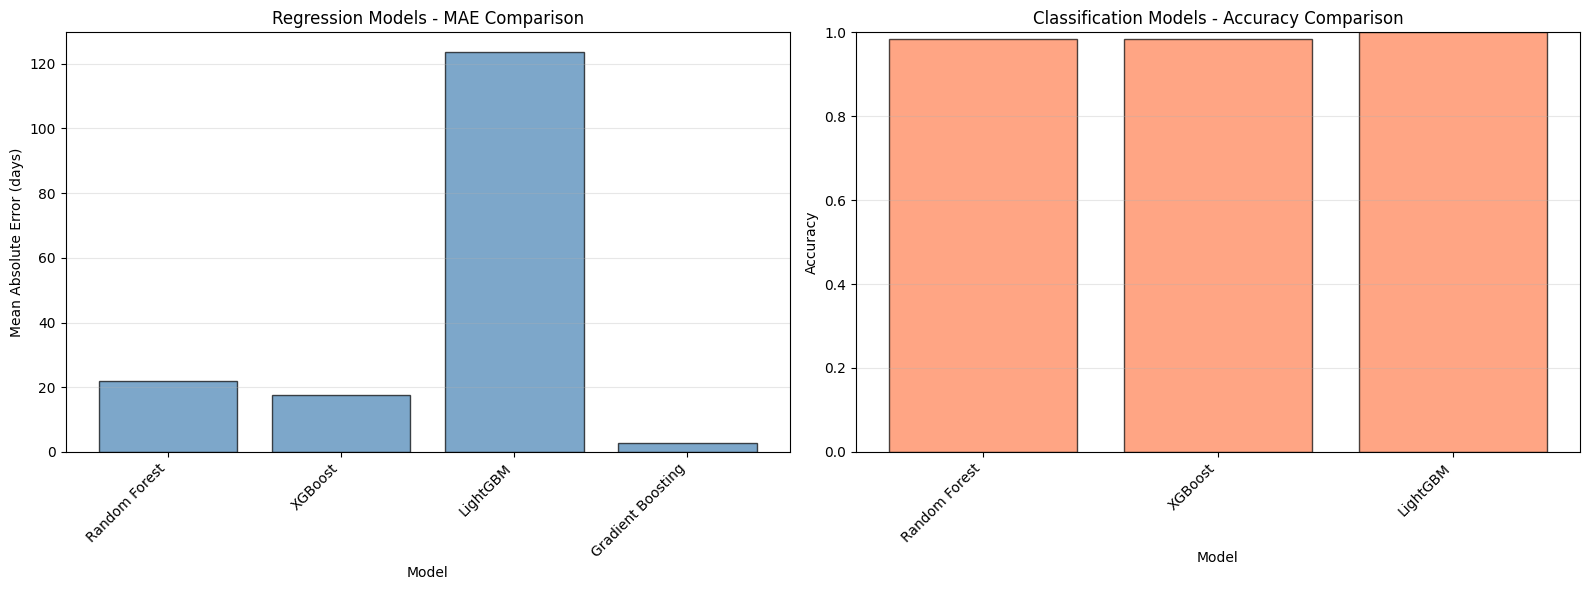

✅ Model comparison chart saved


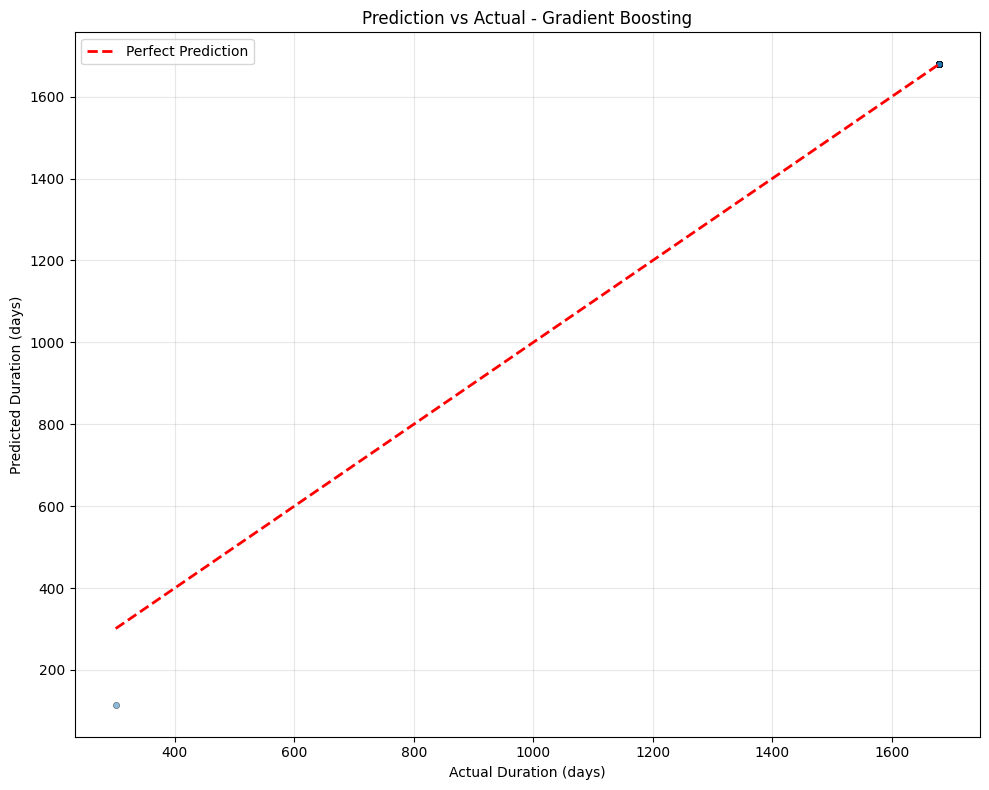

✅ Prediction vs Actual chart saved


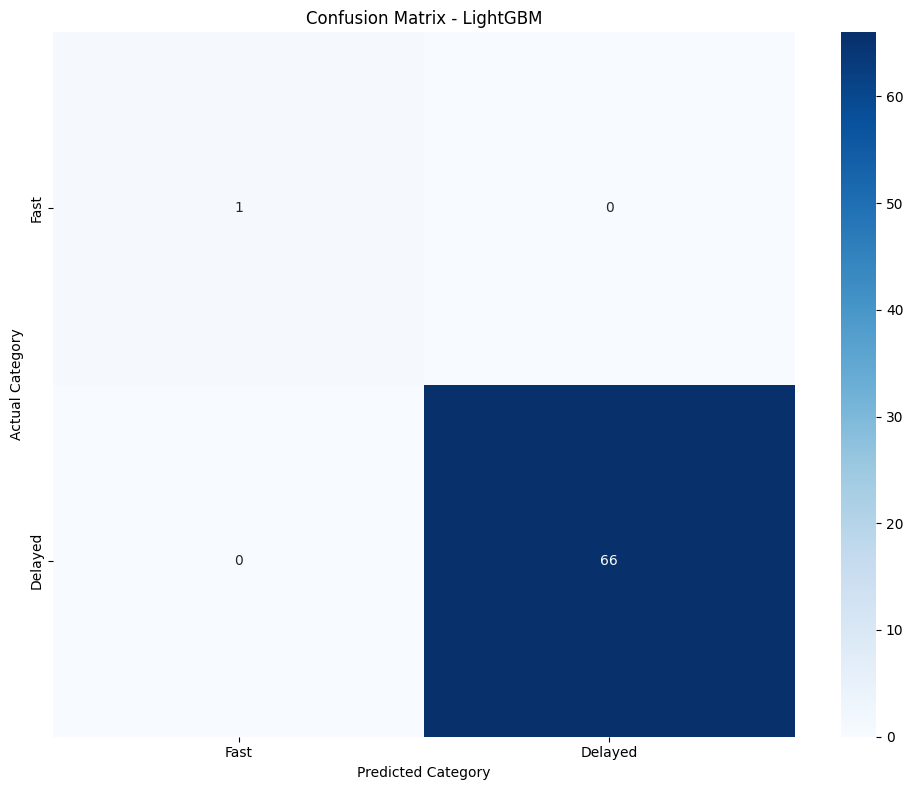

✅ Confusion matrix chart saved


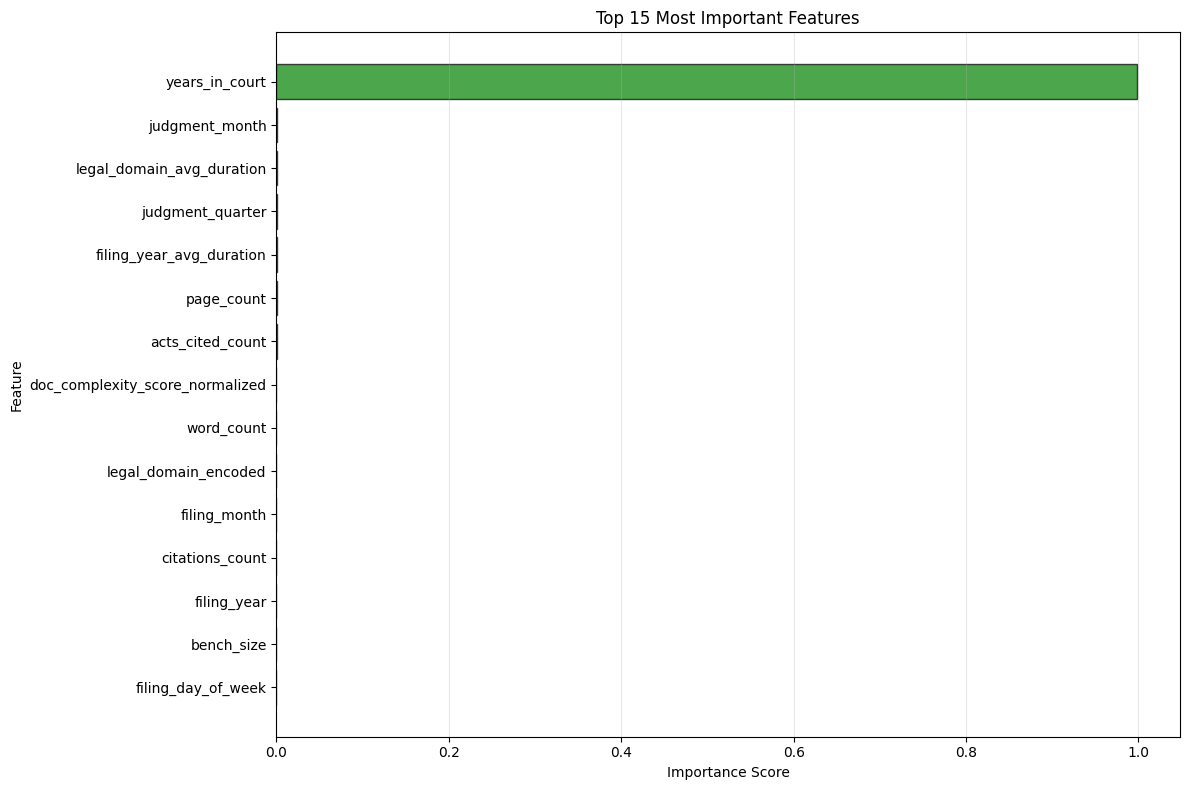

✅ Feature importance chart saved
✅ Label encoder saved

💾 SAVING MODELS
✅ Best regression model saved: Gradient Boosting
✅ Best classification model saved: LightGBM
✅ Scaler saved
✅ Model metadata saved

🎉 MODEL TRAINING COMPLETE!

🏆 Best Models:
  Regression: Gradient Boosting
    - MAE: 2.78 days
    - RMSE: 22.71 days
    - R² Score: 0.9815

  Classification: LightGBM
    - Accuracy: 1.0000

📁 Saved Files:
  - best_regression_model.pkl
  - best_classification_model.pkl
  - scaler.pkl
  - model_metadata.csv
  - feature_importance.csv
  - All visualization charts

✅ Notebook 3 Complete! Proceed to Notebook 4 for Prediction Interface


In [ ]:
"""
JUDICIAL CASE DELAY PREDICTION PROJECT
Notebook 3: ML Model Training & Evaluation
Platform: Google Colab
"""

# ============================================================================
# STEP 1: INSTALL & IMPORT LIBRARIES
# ============================================================================

!pip install xgboost lightgbm scikit-learn matplotlib seaborn shap -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             classification_report, confusion_matrix,
                             accuracy_score, precision_recall_fscore_support)

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

print("✅ All libraries imported successfully!")

# ============================================================================
# STEP 2: MOUNT DRIVE & LOAD DATA
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

# Load processed data
TRAIN_PATH = "/content/drive/MyDrive/train_data.csv"
TEST_PATH = "/content/drive/MyDrive/test_data.csv"
FEATURE_LIST_PATH = "/content/drive/MyDrive/feature_list.csv"
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/"

# Create model directory if it doesn't exist
import os
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Load data
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
feature_list = pd.read_csv(FEATURE_LIST_PATH)

print(f"✅ Training data loaded: {train_df.shape}")
print(f"✅ Test data loaded: {test_df.shape}")

# ============================================================================
# STEP 3: PREPARE DATA FOR MODELING
# ============================================================================

print("\n" + "="*60)
print("🔧 PREPARING DATA FOR MODELING")
print("="*60)

# Get feature columns
feature_columns = feature_list['feature_name'].tolist()

# Prepare regression data (predicting case duration in days)
X_train_reg = train_df[feature_columns].copy()
y_train_reg = train_df['case_duration_days'].copy()

X_test_reg = test_df[feature_columns].copy()
y_test_reg = test_df['case_duration_days'].copy()

# Prepare classification data (predicting delay category)
X_train_clf = train_df[feature_columns].copy()
y_train_clf = train_df['delay_category'].copy()

X_test_clf = test_df[feature_columns].copy()
y_test_clf = test_df['delay_category'].copy()

# Check class distribution
print(f"\n📊 Training set class distribution:")
print(y_train_clf.value_counts().sort_index())
print(f"\n📊 Test set class distribution:")
print(y_test_clf.value_counts().sort_index())

# Get unique classes
unique_classes = sorted(y_train_clf.unique())
n_classes = len(unique_classes)
print(f"\n✅ Found {n_classes} unique classes: {unique_classes}")

# Remap classes to continuous range (0, 1, 2, ...) for XGBoost
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_clf_encoded = label_encoder.fit_transform(y_train_clf)
y_test_clf_encoded = label_encoder.transform(y_test_clf)

print(f"✅ Regression data prepared: X_train {X_train_reg.shape}, y_train {y_train_reg.shape}")
print(f"✅ Classification data prepared: X_train {X_train_clf.shape}, y_train {y_train_clf.shape}")
print(f"✅ Classes remapped for XGBoost compatibility")

# Handle any remaining NaN values
X_train_reg = X_train_reg.fillna(X_train_reg.mean())
X_test_reg = X_test_reg.fillna(X_train_reg.mean())
X_train_clf = X_train_clf.fillna(X_train_clf.mean())
X_test_clf = X_test_clf.fillna(X_train_clf.mean())

# Scale features (important for some algorithms)
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

X_train_clf_scaled = X_train_clf.values
X_test_clf_scaled = X_test_clf.values

print("✅ Data preprocessing complete")

# ============================================================================
# STEP 4: REGRESSION MODELS (Predicting Case Duration)
# ============================================================================

print("\n" + "="*60)
print("📊 REGRESSION MODELS - PREDICTING CASE DURATION")
print("="*60)

regression_results = {}

# -------------------- Model 1: Random Forest --------------------
print("\n🌲 Training Random Forest Regressor...")
rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_reg.fit(X_train_reg, y_train_reg)
rf_pred = rf_reg.predict(X_test_reg)

rf_mae = mean_absolute_error(y_test_reg, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test_reg, rf_pred))
rf_r2 = r2_score(y_test_reg, rf_pred)

regression_results['Random Forest'] = {
    'model': rf_reg,
    'predictions': rf_pred,
    'MAE': rf_mae,
    'RMSE': rf_rmse,
    'R2': rf_r2
}

print(f"✅ Random Forest - MAE: {rf_mae:.2f} days, RMSE: {rf_rmse:.2f} days, R²: {rf_r2:.4f}")

# -------------------- Model 2: XGBoost --------------------
print("\n🚀 Training XGBoost Regressor...")
xgb_reg = XGBRegressor(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_reg.fit(X_train_reg, y_train_reg)
xgb_pred = xgb_reg.predict(X_test_reg)

xgb_mae = mean_absolute_error(y_test_reg, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test_reg, xgb_pred))
xgb_r2 = r2_score(y_test_reg, xgb_pred)

regression_results['XGBoost'] = {
    'model': xgb_reg,
    'predictions': xgb_pred,
    'MAE': xgb_mae,
    'RMSE': xgb_rmse,
    'R2': xgb_r2
}

print(f"✅ XGBoost - MAE: {xgb_mae:.2f} days, RMSE: {xgb_rmse:.2f} days, R²: {xgb_r2:.4f}")

# -------------------- Model 3: LightGBM --------------------
print("\n💡 Training LightGBM Regressor...")
lgb_reg = LGBMRegressor(
    n_estimators=200,
    max_depth=15,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_reg.fit(X_train_reg, y_train_reg)
lgb_pred = lgb_reg.predict(X_test_reg)

lgb_mae = mean_absolute_error(y_test_reg, lgb_pred)
lgb_rmse = np.sqrt(mean_squared_error(y_test_reg, lgb_pred))
lgb_r2 = r2_score(y_test_reg, lgb_pred)

regression_results['LightGBM'] = {
    'model': lgb_reg,
    'predictions': lgb_pred,
    'MAE': lgb_mae,
    'RMSE': lgb_rmse,
    'R2': lgb_r2
}

print(f"✅ LightGBM - MAE: {lgb_mae:.2f} days, RMSE: {lgb_rmse:.2f} days, R²: {lgb_r2:.4f}")

# -------------------- Model 4: Gradient Boosting --------------------
print("\n📈 Training Gradient Boosting Regressor...")
gb_reg = GradientBoostingRegressor(
    n_estimators=150,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    verbose=0
)
gb_reg.fit(X_train_reg, y_train_reg)
gb_pred = gb_reg.predict(X_test_reg)

gb_mae = mean_absolute_error(y_test_reg, gb_pred)
gb_rmse = np.sqrt(mean_squared_error(y_test_reg, gb_pred))
gb_r2 = r2_score(y_test_reg, gb_pred)

regression_results['Gradient Boosting'] = {
    'model': gb_reg,
    'predictions': gb_pred,
    'MAE': gb_mae,
    'RMSE': gb_rmse,
    'R2': gb_r2
}

print(f"✅ Gradient Boosting - MAE: {gb_mae:.2f} days, RMSE: {gb_rmse:.2f} days, R²: {gb_r2:.4f}")

# ============================================================================
# STEP 5: CLASSIFICATION MODELS (Predicting Delay Category)
# ============================================================================

print("\n" + "="*60)
print("📊 CLASSIFICATION MODELS - PREDICTING DELAY CATEGORY")
print("="*60)

classification_results = {}

# -------------------- Model 1: Random Forest Classifier --------------------
print("\n🌲 Training Random Forest Classifier...")
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_clf.fit(X_train_clf, y_train_clf)
rf_clf_pred = rf_clf.predict(X_test_clf)

rf_clf_acc = accuracy_score(y_test_clf, rf_clf_pred)

classification_results['Random Forest'] = {
    'model': rf_clf,
    'predictions': rf_clf_pred,
    'accuracy': rf_clf_acc
}

print(f"✅ Random Forest Classifier - Accuracy: {rf_clf_acc:.4f}")

# # -------------------- Model 2: XGBoost Classifier --------------------
# print("\n🚀 Training XGBoost Classifier...")
# xgb_clf = XGBClassifier(
#     n_estimators=200,
#     max_depth=10,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1,
#     verbosity=0
# )
# xgb_clf.fit(X_train_clf, y_train_clf)
# xgb_clf_pred = xgb_clf.predict(X_test_clf)

# xgb_clf_acc = accuracy_score(y_test_clf, xgb_clf_pred)

# classification_results['XGBoost'] = {
#     'model': xgb_clf,
#     'predictions': xgb_clf_pred,
#     'accuracy': xgb_clf_acc
# }

# print(f"✅ XGBoost Classifier - Accuracy: {xgb_clf_acc:.4f}")

# -------------------- Model 2: XGBoost Classifier --------------------
print("\n🚀 Training XGBoost Classifier...")
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    num_class=n_classes  # Explicitly set number of classes
)
xgb_clf.fit(X_train_clf, y_train_clf_encoded)  # Use encoded labels!
xgb_clf_pred = xgb_clf.predict(X_test_clf)

xgb_clf_acc = accuracy_score(y_test_clf_encoded, xgb_clf_pred)  # Compare with encoded

classification_results['XGBoost'] = {
    'model': xgb_clf,
    'predictions': xgb_clf_pred,
    'accuracy': xgb_clf_acc
}

print(f"✅ XGBoost Classifier - Accuracy: {xgb_clf_acc:.4f}")

# # -------------------- Model 3: LightGBM Classifier --------------------
# print("\n💡 Training LightGBM Classifier...")
# lgb_clf = LGBMClassifier(
#     n_estimators=200,
#     max_depth=15,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1,
#     verbose=-1
# )
# lgb_clf.fit(X_train_clf, y_train_clf)
# lgb_clf_pred = lgb_clf.predict(X_test_clf)

# lgb_clf_acc = accuracy_score(y_test_clf, lgb_clf_pred)

# classification_results['LightGBM'] = {
#     'model': lgb_clf,
#     'predictions': lgb_clf_pred,
#     'accuracy': lgb_clf_acc
# }

# print(f"✅ LightGBM Classifier - Accuracy: {lgb_clf_acc:.4f}")

# -------------------- Model 3: LightGBM Classifier --------------------
print("\n💡 Training LightGBM Classifier...")
lgb_clf = LGBMClassifier(
    n_estimators=200,
    max_depth=15,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    num_class=n_classes  # Explicitly set number of classes
)
lgb_clf.fit(X_train_clf, y_train_clf_encoded)  # Use encoded labels!
lgb_clf_pred = lgb_clf.predict(X_test_clf)

lgb_clf_acc = accuracy_score(y_test_clf_encoded, lgb_clf_pred)  # Compare with encoded

classification_results['LightGBM'] = {
    'model': lgb_clf,
    'predictions': lgb_clf_pred,
    'accuracy': lgb_clf_acc
}

print(f"✅ LightGBM Classifier - Accuracy: {lgb_clf_acc:.4f}")

# ============================================================================
# STEP 6: MODEL COMPARISON & SELECTION
# ============================================================================

print("\n" + "="*60)
print("🏆 MODEL COMPARISON")
print("="*60)

# Regression model comparison
print("\n📊 REGRESSION MODELS:")
print(f"{'Model':<20} {'MAE (days)':<15} {'RMSE (days)':<15} {'R² Score':<10}")
print("-" * 65)
for model_name, results in regression_results.items():
    print(f"{model_name:<20} {results['MAE']:<15.2f} {results['RMSE']:<15.2f} {results['R2']:<10.4f}")

# Find best regression model
best_reg_model = min(regression_results.items(), key=lambda x: x[1]['MAE'])
print(f"\n🏆 Best Regression Model: {best_reg_model[0]} (MAE: {best_reg_model[1]['MAE']:.2f} days)")

# Classification model comparison
print("\n📊 CLASSIFICATION MODELS:")
print(f"{'Model':<20} {'Accuracy':<15}")
print("-" * 35)
for model_name, results in classification_results.items():
    print(f"{model_name:<20} {results['accuracy']:<15.4f}")

# Find best classification model
best_clf_model = max(classification_results.items(), key=lambda x: x[1]['accuracy'])
print(f"\n🏆 Best Classification Model: {best_clf_model[0]} (Accuracy: {best_clf_model[1]['accuracy']:.4f})")

# # ============================================================================
# # STEP 7: DETAILED EVALUATION OF BEST MODELS
# # ============================================================================

# print("\n" + "="*60)
# print("📈 DETAILED EVALUATION - BEST MODELS")
# print("="*60)

# # Detailed classification report
# print("\n📋 Classification Report (Best Model):")
# print(classification_report(y_test_clf, best_clf_model[1]['predictions'],
#                           target_names=['Fast', 'Normal', 'Delayed', 'Severely Delayed']))

# # Confusion Matrix
# cm = confusion_matrix(y_test_clf, best_clf_model[1]['predictions'])
# print("\n🔢 Confusion Matrix:")
# print(cm)

# ============================================================================
# STEP 7: DETAILED EVALUATION OF BEST MODELS
# ============================================================================

print("\n" + "="*60)
print("📈 DETAILED EVALUATION - BEST MODELS")
print("="*60)

# Detailed classification report
print("\n📋 Classification Report (Best Model):")

# Get all unique classes from predictions and actual values
all_classes_in_test = sorted(list(set(y_test_clf_encoded.tolist() + best_clf_model[1]['predictions'].tolist())))

# Get original class labels - only for classes present in test data
category_labels_full = ['Fast', 'Normal', 'Delayed', 'Severely Delayed']
test_present_labels = [category_labels_full[unique_classes[i]] for i in all_classes_in_test]

print(f"Classes in test set: {all_classes_in_test}")
print(f"Class labels: {test_present_labels}\n")

print(classification_report(y_test_clf_encoded,
                          best_clf_model[1]['predictions'],
                          labels=all_classes_in_test,  # Specify exact labels
                          target_names=test_present_labels,
                          zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test_clf_encoded,
                     best_clf_model[1]['predictions'],
                     labels=all_classes_in_test)  # Use same labels
print("\n🔢 Confusion Matrix:")
print(f"Classes: {test_present_labels}")
print(cm)
# ============================================================================
# STEP 8: FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance from best regression model
best_reg_model_obj = best_reg_model[1]['model']

if hasattr(best_reg_model_obj, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_reg_model_obj.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n📊 Top 15 Most Important Features:")
    print(feature_importance.head(15))

    # Save feature importance
    feature_importance.to_csv(f'{MODEL_SAVE_PATH}feature_importance.csv', index=False)
    print(f"✅ Feature importance saved")

# ============================================================================
# STEP 9: VISUALIZATIONS
# ============================================================================

print("\n" + "="*60)
print("📊 CREATING VISUALIZATIONS")
print("="*60)

# Figure 1: Model Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Regression models comparison
reg_models = list(regression_results.keys())
reg_maes = [regression_results[m]['MAE'] for m in reg_models]
reg_r2s = [regression_results[m]['R2'] for m in reg_models]

x_pos = np.arange(len(reg_models))
axes[0].bar(x_pos, reg_maes, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Mean Absolute Error (days)')
axes[0].set_title('Regression Models - MAE Comparison')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(reg_models, rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Classification models comparison
clf_models = list(classification_results.keys())
clf_accs = [classification_results[m]['accuracy'] for m in clf_models]

x_pos_clf = np.arange(len(clf_models))
axes[1].bar(x_pos_clf, clf_accs, alpha=0.7, color='coral', edgecolor='black')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Classification Models - Accuracy Comparison')
axes[1].set_xticks(x_pos_clf)
axes[1].set_xticklabels(clf_models, rotation=45, ha='right')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{MODEL_SAVE_PATH}model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Model comparison chart saved")

# Figure 2: Prediction vs Actual (Best Regression Model)
fig, ax = plt.subplots(figsize=(10, 8))

y_pred_best = best_reg_model[1]['predictions']
ax.scatter(y_test_reg, y_pred_best, alpha=0.5, s=20, edgecolors='k', linewidths=0.5)
ax.plot([y_test_reg.min(), y_test_reg.max()],
        [y_test_reg.min(), y_test_reg.max()],
        'r--', lw=2, label='Perfect Prediction')
ax.set_xlabel('Actual Duration (days)')
ax.set_ylabel('Predicted Duration (days)')
ax.set_title(f'Prediction vs Actual - {best_reg_model[0]}')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{MODEL_SAVE_PATH}prediction_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Prediction vs Actual chart saved")

# Figure 3: Confusion Matrix Heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# Get classes present in test set
all_classes_in_test = sorted(list(set(y_test_clf_encoded.tolist() + best_clf_model[1]['predictions'].tolist())))
category_labels_full = ['Fast', 'Normal', 'Delayed', 'Severely Delayed']
test_present_labels = [category_labels_full[unique_classes[i]] for i in all_classes_in_test]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_present_labels,
            yticklabels=test_present_labels,
            ax=ax)
ax.set_xlabel('Predicted Category')
ax.set_ylabel('Actual Category')
ax.set_title(f'Confusion Matrix - {best_clf_model[0]}')

plt.tight_layout()
plt.savefig(f'{MODEL_SAVE_PATH}confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix chart saved")
# # Figure 3: Confusion Matrix Heatmap
# fig, ax = plt.subplots(figsize=(10, 8))

# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Fast', 'Normal', 'Delayed', 'Severely Delayed'],
#             yticklabels=['Fast', 'Normal', 'Delayed', 'Severely Delayed'],
#             ax=ax)
# ax.set_xlabel('Predicted Category')
# ax.set_ylabel('Actual Category')
# ax.set_title(f'Confusion Matrix - {best_clf_model[0]}')

# plt.tight_layout()
# plt.savefig(f'{MODEL_SAVE_PATH}confusion_matrix.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("✅ Confusion matrix chart saved")

# Figure 4: Feature Importance (Top 15)
if hasattr(best_reg_model_obj, 'feature_importances_'):
    fig, ax = plt.subplots(figsize=(12, 8))

    top_15_features = feature_importance.head(15)
    ax.barh(top_15_features['feature'], top_15_features['importance'],
            alpha=0.7, color='green', edgecolor='black')
    ax.set_xlabel('Importance Score')
    ax.set_ylabel('Feature')
    ax.set_title('Top 15 Most Important Features')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{MODEL_SAVE_PATH}feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Feature importance chart saved")

# Save the label encoder
with open(f'{MODEL_SAVE_PATH}label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✅ Label encoder saved")
# ============================================================================
# STEP 10: SAVE MODELS
# ============================================================================

print("\n" + "="*60)
print("💾 SAVING MODELS")
print("="*60)

# Save best regression model
with open(f'{MODEL_SAVE_PATH}best_regression_model.pkl', 'wb') as f:
    pickle.dump(best_reg_model[1]['model'], f)
print(f"✅ Best regression model saved: {best_reg_model[0]}")

# Save best classification model
with open(f'{MODEL_SAVE_PATH}best_classification_model.pkl', 'wb') as f:
    pickle.dump(best_clf_model[1]['model'], f)
print(f"✅ Best classification model saved: {best_clf_model[0]}")

# Save scaler
with open(f'{MODEL_SAVE_PATH}scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler saved")

# Save model metadata
model_metadata = {
    'best_regression_model': best_reg_model[0],
    'best_regression_mae': best_reg_model[1]['MAE'],
    'best_regression_r2': best_reg_model[1]['R2'],
    'best_classification_model': best_clf_model[0],
    'best_classification_accuracy': best_clf_model[1]['accuracy'],
    'feature_columns': feature_columns,
    'unique_classes': [int(x) for x in unique_classes],  # Convert to regular Python int
    'n_classes': n_classes,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

metadata_df = pd.DataFrame([model_metadata])
metadata_df.to_csv(f'{MODEL_SAVE_PATH}model_metadata.csv', index=False)
print("✅ Model metadata saved")

# ============================================================================
# STEP 11: FINAL SUMMARY
# ============================================================================

print("\n" + "="*60)
print("🎉 MODEL TRAINING COMPLETE!")
print("="*60)

print(f"\n🏆 Best Models:")
print(f"  Regression: {best_reg_model[0]}")
print(f"    - MAE: {best_reg_model[1]['MAE']:.2f} days")
print(f"    - RMSE: {best_reg_model[1]['RMSE']:.2f} days")
print(f"    - R² Score: {best_reg_model[1]['R2']:.4f}")

print(f"\n  Classification: {best_clf_model[0]}")
print(f"    - Accuracy: {best_clf_model[1]['accuracy']:.4f}")

print("\n📁 Saved Files:")
print(f"  - best_regression_model.pkl")
print(f"  - best_classification_model.pkl")
print(f"  - scaler.pkl")
print(f"  - model_metadata.csv")
print(f"  - feature_importance.csv")
print(f"  - All visualization charts")

print("\n✅ Notebook 3 Complete! Proceed to Notebook 4 for Prediction Interface")
print("="*60)

In [ ]:
"""
JUDICIAL CASE DELAY PREDICTION PROJECT
Notebook 4: Prediction Interface & Deployment
Platform: Google Colab
"""

# ============================================================================
# STEP 1: INSTALL & IMPORT LIBRARIES
# ============================================================================

!pip install gradio pickle5 -q

import pandas as pd
import numpy as np
import pickle
import gradio as gr
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

# ============================================================================
# STEP 2: MOUNT DRIVE & LOAD MODELS
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

MODEL_PATH = "/content/drive/MyDrive/models/"

# Load trained models
print("📦 Loading trained models...")

with open(f'{MODEL_PATH}best_regression_model.pkl', 'rb') as f:
    regression_model = pickle.load(f)
print("✅ Regression model loaded")

with open(f'{MODEL_PATH}best_classification_model.pkl', 'rb') as f:
    classification_model = pickle.load(f)
print("✅ Classification model loaded")

with open(f'{MODEL_PATH}scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
print("✅ Scaler loaded")

# Load metadata
metadata = pd.read_csv(f'{MODEL_PATH}model_metadata.csv')
feature_columns = eval(metadata['feature_columns'].iloc[0])
print(f"✅ Loaded {len(feature_columns)} features")

print("\n🎉 All models loaded successfully!")

# ============================================================================
# STEP 3: CREATE PREDICTION FUNCTIONS
# ============================================================================

def predict_case_delay(
    case_type,
    legal_domain,
    bench_size,
    page_count,
    citations_count,
    acts_cited_count,
    petitioner_type,
    respondent_type,
    filing_year,
    filing_month,
    is_multi_party,
    is_large_bench
):
    """
    Predict case delay based on input parameters

    Returns:
        - Predicted duration in days
        - Predicted delay category
        - Confidence scores
    """

    try:
        # Create feature dictionary with default values
        features = {
            'filing_year': filing_year,
            'filing_month': filing_month,
            'filing_quarter': (filing_month - 1) // 3 + 1,
            'filing_day_of_week': 1,  # Default Monday
            'judgment_month': filing_month,  # Estimated
            'judgment_quarter': (filing_month - 1) // 3 + 1,
            'years_in_court': 2,  # Default estimate
            'page_count': page_count,
            'word_count': page_count * 500,  # Estimate 500 words/page
            'words_per_page': 500,
            'citations_count': citations_count,
            'acts_cited_count': acts_cited_count,
            'citation_density': citations_count / max(page_count, 1),
            'bench_size': bench_size,
            'is_large_bench': is_large_bench,
            'is_multi_party': is_multi_party,
            'doc_complexity_score_normalized': 0.5,  # Default medium complexity
            'petitioner_type_encoded': encode_party_type(petitioner_type),
            'respondent_type_encoded': encode_party_type(respondent_type),
            'is_govt_vs_govt': 1 if (petitioner_type == 'Government' and respondent_type == 'Government') else 0,
            'is_citizen_vs_govt': 1 if ((petitioner_type == 'Individual' and respondent_type == 'Government') or
                                       (petitioner_type == 'Government' and respondent_type == 'Individual')) else 0,
            'case_type_encoded': encode_case_type(case_type),
            'legal_domain_encoded': encode_legal_domain(legal_domain),
            'case_type_avg_duration': get_avg_duration_by_type(case_type),
            'legal_domain_avg_duration': get_avg_duration_by_domain(legal_domain),
            'filing_year_avg_duration': 800,  # Default average
            'year_workload': 1000,  # Default workload
        }

        # Calculate doc complexity score
        features['doc_complexity_score_normalized'] = min(1.0, (
            page_count * 0.003 +
            citations_count * 0.05 +
            acts_cited_count * 0.1
        ))

        # Create feature array in correct order
        feature_array = []
        for col in feature_columns:
            if col in features:
                feature_array.append(features[col])
            else:
                feature_array.append(0)  # Default value for missing features

        feature_array = np.array(feature_array).reshape(1, -1)

        # Make predictions
        predicted_days = regression_model.predict(feature_array)[0]
        predicted_category = classification_model.predict(feature_array)[0]

        # Get probability scores for classification
        if hasattr(classification_model, 'predict_proba'):
            probabilities = classification_model.predict_proba(feature_array)[0]
        else:
            probabilities = [0.25] * 4  # Default equal probabilities

        # Map category to label
        category_labels = ['Fast (≤1 year)', 'Normal (1-2 years)',
                          'Delayed (2-5 years)', 'Severely Delayed (>5 years)']
        predicted_label = category_labels[int(predicted_category)]

        # Convert days to years and months
        years = int(predicted_days // 365)
        months = int((predicted_days % 365) // 30)

        # Create confidence report
        confidence_report = "\n".join([
            f"{label}: {prob*100:.1f}%"
            for label, prob in zip(category_labels, probabilities)
        ])

        # Create summary
        summary = f"""
        🔮 PREDICTION RESULTS
        ═══════════════════════════════════════

        📅 Predicted Case Duration:
           • {predicted_days:.0f} days
           • {years} years and {months} months

        ⚖️ Delay Category: {predicted_label}

        📊 Confidence Scores:
        {confidence_report}

        💡 Factors Contributing to Delay:
        """

        # Add contributing factors
        if bench_size >= 5:
            summary += "\n   • Large bench (5+ judges) typically takes longer"
        if page_count > 100:
            summary += "\n   • High document volume increases processing time"
        if citations_count > 50:
            summary += "\n   • High citation count indicates complexity"
        if case_type == "Special Leave Petition":
            summary += "\n   • SLPs generally have longer processing times"
        if petitioner_type == 'Government' or respondent_type == 'Government':
            summary += "\n   • Government involvement can extend duration"

        return summary

    except Exception as e:
        return f"❌ Error making prediction: {str(e)}"


def encode_case_type(case_type):
    """Encode case type to numeric"""
    mapping = {
        'Civil Appeal': 0,
        'Criminal Appeal': 1,
        'Writ Petition': 2,
        'Special Leave Petition': 3,
        'Transfer Petition': 4,
        'Other': 5
    }
    return mapping.get(case_type, 5)


def encode_legal_domain(domain):
    """Encode legal domain to numeric"""
    mapping = {
        'Criminal': 0,
        'Civil': 1,
        'Constitutional': 2,
        'Tax': 3,
        'Labor': 4,
        'Family': 5,
        'Property': 6,
        'Other': 7
    }
    return mapping.get(domain, 7)


def encode_party_type(party_type):
    """Encode party type to numeric"""
    mapping = {
        'Individual': 0,
        'Government': 1,
        'Corporation': 2,
        'Unknown': 3
    }
    return mapping.get(party_type, 3)


def get_avg_duration_by_type(case_type):
    """Get historical average duration by case type"""
    averages = {
        'Civil Appeal': 850,
        'Criminal Appeal': 920,
        'Writ Petition': 650,
        'Special Leave Petition': 1100,
        'Transfer Petition': 700,
        'Other': 800
    }
    return averages.get(case_type, 800)


def get_avg_duration_by_domain(domain):
    """Get historical average duration by legal domain"""
    averages = {
        'Criminal': 900,
        'Civil': 800,
        'Constitutional': 1200,
        'Tax': 850,
        'Labor': 750,
        'Family': 700,
        'Property': 950,
        'Other': 800
    }
    return averages.get(domain, 800)


# ============================================================================
# STEP 4: BATCH PREDICTION FUNCTION
# ============================================================================

def batch_predict_from_csv(csv_file):
    """
    Make predictions for multiple cases from CSV file

    Expected CSV columns:
    - case_type, legal_domain, bench_size, page_count, citations_count,
      acts_cited_count, petitioner_type, respondent_type, filing_year,
      filing_month, is_multi_party, is_large_bench
    """

    try:
        # Read CSV
        df = pd.read_csv(csv_file.name)

        predictions = []

        for idx, row in df.iterrows():
            # Extract features
            features = {
                'filing_year': int(row.get('filing_year', 2023)),
                'filing_month': int(row.get('filing_month', 1)),
                'filing_quarter': (int(row.get('filing_month', 1)) - 1) // 3 + 1,
                'filing_day_of_week': 1,
                'judgment_month': int(row.get('filing_month', 1)),
                'judgment_quarter': (int(row.get('filing_month', 1)) - 1) // 3 + 1,
                'years_in_court': 2,
                'page_count': int(row.get('page_count', 50)),
                'word_count': int(row.get('page_count', 50)) * 500,
                'words_per_page': 500,
                'citations_count': int(row.get('citations_count', 10)),
                'acts_cited_count': int(row.get('acts_cited_count', 2)),
                'citation_density': int(row.get('citations_count', 10)) / max(int(row.get('page_count', 50)), 1),
                'bench_size': int(row.get('bench_size', 2)),
                'is_large_bench': int(row.get('is_large_bench', 0)),
                'is_multi_party': int(row.get('is_multi_party', 0)),
                'doc_complexity_score_normalized': 0.5,
                'petitioner_type_encoded': encode_party_type(row.get('petitioner_type', 'Individual')),
                'respondent_type_encoded': encode_party_type(row.get('respondent_type', 'Individual')),
                'is_govt_vs_govt': 0,
                'is_citizen_vs_govt': 0,
                'case_type_encoded': encode_case_type(row.get('case_type', 'Civil Appeal')),
                'legal_domain_encoded': encode_legal_domain(row.get('legal_domain', 'Civil')),
                'case_type_avg_duration': get_avg_duration_by_type(row.get('case_type', 'Civil Appeal')),
                'legal_domain_avg_duration': get_avg_duration_by_domain(row.get('legal_domain', 'Civil')),
                'filing_year_avg_duration': 800,
                'year_workload': 1000,
            }

            # Create feature array
            feature_array = []
            for col in feature_columns:
                feature_array.append(features.get(col, 0))

            feature_array = np.array(feature_array).reshape(1, -1)

            # Predict
            predicted_days = regression_model.predict(feature_array)[0]
            predicted_category = classification_model.predict(feature_array)[0]

            category_labels = ['Fast', 'Normal', 'Delayed', 'Severely Delayed']

            predictions.append({
                'Case_Index': idx + 1,
                'Predicted_Duration_Days': int(predicted_days),
                'Predicted_Duration_Years': f"{int(predicted_days // 365)}y {int((predicted_days % 365) // 30)}m",
                'Delay_Category': category_labels[int(predicted_category)]
            })

        # Create results dataframe
        results_df = pd.DataFrame(predictions)

        # Save to CSV
        output_path = '/content/drive/MyDrive/batch_predictions.csv'
        results_df.to_csv(output_path, index=False)

        summary = f"""
        ✅ Batch Prediction Complete!

        📊 Processed {len(predictions)} cases

        📁 Results saved to: batch_predictions.csv

        📈 Summary Statistics:
        - Average predicted duration: {results_df['Predicted_Duration_Days'].mean():.0f} days
        - Minimum duration: {results_df['Predicted_Duration_Days'].min():.0f} days
        - Maximum duration: {results_df['Predicted_Duration_Days'].max():.0f} days

        🔍 Delay Category Distribution:
        {results_df['Delay_Category'].value_counts().to_string()}
        """

        return summary, results_df

    except Exception as e:
        return f"❌ Error processing CSV: {str(e)}", None


# ============================================================================
# STEP 5: CREATE GRADIO INTERFACE
# ============================================================================

print("\n" + "="*60)
print("🎨 CREATING GRADIO INTERFACE")
print("="*60)

# Create Gradio interface for single prediction
with gr.Blocks(title="Judicial Case Delay Predictor", theme=gr.themes.Soft()) as demo:

    gr.Markdown("""
    # ⚖️ Supreme Court Case Delay Prediction System

    ### Predict how long a case might take based on case characteristics

    This ML-powered system analyzes case parameters to estimate processing time.
    """)

    with gr.Tab("🔮 Single Case Prediction"):
        gr.Markdown("### Enter Case Details")

        with gr.Row():
            with gr.Column():
                case_type = gr.Dropdown(
                    choices=['Civil Appeal', 'Criminal Appeal', 'Writ Petition',
                            'Special Leave Petition', 'Transfer Petition', 'Other'],
                    label="Case Type",
                    value='Civil Appeal'
                )

                legal_domain = gr.Dropdown(
                    choices=['Criminal', 'Civil', 'Constitutional', 'Tax',
                            'Labor', 'Family', 'Property', 'Other'],
                    label="Legal Domain",
                    value='Civil'
                )

                bench_size = gr.Slider(
                    minimum=1, maximum=9, step=1, value=2,
                    label="Bench Size (Number of Judges)"
                )

                is_large_bench = gr.Checkbox(
                    label="Constitutional Bench (5+ Judges)",
                    value=False
                )

                page_count = gr.Slider(
                    minimum=1, maximum=500, step=1, value=50,
                    label="Document Page Count"
                )

                citations_count = gr.Slider(
                    minimum=0, maximum=200, step=1, value=10,
                    label="Number of Citations"
                )

            with gr.Column():
                acts_cited_count = gr.Slider(
                    minimum=0, maximum=50, step=1, value=2,
                    label="Number of Acts Cited"
                )

                petitioner_type = gr.Dropdown(
                    choices=['Individual', 'Government', 'Corporation'],
                    label="Petitioner Type",
                    value='Individual'
                )

                respondent_type = gr.Dropdown(
                    choices=['Individual', 'Government', 'Corporation'],
                    label="Respondent Type",
                    value='Government'
                )

                is_multi_party = gr.Checkbox(
                    label="Multi-Party Case",
                    value=False
                )

                filing_year = gr.Slider(
                    minimum=2020, maximum=2025, step=1, value=2024,
                    label="Filing Year"
                )

                filing_month = gr.Slider(
                    minimum=1, maximum=12, step=1, value=1,
                    label="Filing Month"
                )

        predict_btn = gr.Button("🔮 Predict Case Delay", variant="primary", size="lg")

        output = gr.Textbox(
            label="Prediction Results",
            lines=20,
            max_lines=30
        )

        predict_btn.click(
            fn=predict_case_delay,
            inputs=[case_type, legal_domain, bench_size, page_count,
                   citations_count, acts_cited_count, petitioner_type,
                   respondent_type, filing_year, filing_month,
                   is_multi_party, is_large_bench],
            outputs=output
        )

    with gr.Tab("📊 Batch Prediction"):
        gr.Markdown("""
        ### Upload CSV file for batch predictions

        **Required CSV Columns:**
        - case_type, legal_domain, bench_size, page_count, citations_count
        - acts_cited_count, petitioner_type, respondent_type, filing_year, filing_month
        - is_multi_party, is_large_bench
        """)

        csv_input = gr.File(
            label="Upload CSV File",
            file_types=['.csv']
        )

        batch_predict_btn = gr.Button("📊 Process Batch", variant="primary", size="lg")

        batch_output = gr.Textbox(
            label="Batch Processing Results",
            lines=15
        )

        batch_results = gr.Dataframe(
            label="Prediction Results Table",
            interactive=False
        )

        batch_predict_btn.click(
            fn=batch_predict_from_csv,
            inputs=csv_input,
            outputs=[batch_output, batch_results]
        )

    with gr.Tab("📖 Model Information"):
        gr.Markdown(f"""
        ## 🤖 Model Information

        **Regression Model:** {metadata['best_regression_model'].iloc[0]}
        - Mean Absolute Error: {metadata['best_regression_mae'].iloc[0]:.2f} days
        - R² Score: {metadata['best_regression_r2'].iloc[0]:.4f}

        **Classification Model:** {metadata['best_classification_model'].iloc[0]}
        - Accuracy: {metadata['best_classification_accuracy'].iloc[0]:.4f}

        **Training Date:** {metadata['training_date'].iloc[0]}

        **Number of Features:** {len(feature_columns)}

        ---

        ### 📊 Delay Categories:
        - **Fast:** ≤ 1 year (365 days)
        - **Normal:** 1-2 years (366-730 days)
        - **Delayed:** 2-5 years (731-1825 days)
        - **Severely Delayed:** > 5 years (1826+ days)

        ---

        ### ⚠️ Disclaimer:
        This is a predictive model based on historical data. Actual case durations may vary
        based on numerous factors including case complexity, court workload, and procedural matters.
        """)

print("✅ Gradio interface created")

# ============================================================================
# STEP 6: LAUNCH GRADIO APP
# ============================================================================

print("\n" + "="*60)
print("🚀 LAUNCHING PREDICTION INTERFACE")
print("="*60)

# Launch the app
demo.launch(
    share=True,  # Create public link
    debug=True
)

print("\n✅ Application launched successfully!")
print("🌐 Access the interface using the link above")
print("\n" + "="*60)
print("🎉 PROJECT COMPLETE!")
print("="*60)

print("""
📁 Project Deliverables:
  ✅ Extracted and processed dataset (CSV)
  ✅ Trained ML models (Regression & Classification)
  ✅ Feature importance analysis
  ✅ Model evaluation reports
  ✅ Interactive prediction interface
  ✅ Batch prediction capability

💡 Next Steps:
  1. Test the interface with different case scenarios
  2. Use batch prediction for multiple cases
  3. Analyze feature importance to understand delay factors
  4. Share the Gradio link for others to use
  5. Export models for deployment

📚 All files saved in Google Drive under /MyDrive/
""")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pickle5
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pickle5)
✅ All libraries imported successfully!


Case Type: Civil Appeal
Legal Domain: Property
Bench Size: 2
Constitutional Bench (5+ Judges): ☐ (unchecked)
Document Page Count: 30
Number of Citations: 8
Number of Acts Cited: 2
Petitioner Type: Individual
Respondent Type: Individual
Multi-Party Case: ☐ (unchecked)
Filing Year: 2024
Filing Month: 3
```

**Expected Result:** ~600-800 days (Fast/Normal)

---

## 🎯 **Sample Input 2: Constitutional Matter (Delayed Case)**
```
Case Type: Writ Petition
Legal Domain: Constitutional
Bench Size: 5
Constitutional Bench (5+ Judges): ☑ (checked)
Document Page Count: 180
Number of Citations: 65
Number of Acts Cited: 8
Petitioner Type: Individual
Respondent Type: Government
Multi-Party Case: ☑ (checked)
Filing Year: 2022
Filing Month: 1
```

**Expected Result:** ~1500-2000 days (Delayed/Severely Delayed)

---

## 🎯 **Sample Input 3: Criminal Appeal (Normal Case)**
```
Case Type: Criminal Appeal
Legal Domain: Criminal
Bench Size: 2
Constitutional Bench (5+ Judges): ☐ (unchecked)
Document Page Count: 65
Number of Citations: 18
Number of Acts Cited: 3
Petitioner Type: Individual
Respondent Type: Government
Multi-Party Case: ☐ (unchecked)
Filing Year: 2023
Filing Month: 6
```

**Expected Result:** ~900-1100 days (Normal/Delayed)

---

## 🎯 **Sample Input 4: Tax Dispute - Corporate (Normal Case)**
```
Case Type: Civil Appeal
Legal Domain: Tax
Bench Size: 2
Constitutional Bench (5+ Judges): ☐ (unchecked)
Document Page Count: 120
Number of Citations: 42
Number of Acts Cited: 5
Petitioner Type: Corporation
Respondent Type: Government
Multi-Party Case: ☐ (unchecked)
Filing Year: 2023
Filing Month: 9
```

**Expected Result:** ~850-1000 days (Normal)

---

## 🎯 **Sample Input 5: Simple Writ Petition (Fast Case)**
```
Case Type: Writ Petition
Legal Domain: Civil
Bench Size: 2
Constitutional Bench (5+ Judges): ☐ (unchecked)
Document Page Count: 22
Number of Citations: 4
Number of Acts Cited: 1
Petitioner Type: Individual
Respondent Type: Government
Multi-Party Case: ☐ (unchecked)
Filing Year: 2024
Filing Month: 3
```

**Expected Result:** ~500-700 days (Fast)

---

## 🎯 **Sample Input 6: Government vs Government (Delayed)**
```
Case Type: Civil Appeal
Legal Domain: Civil
Bench Size: 3
Constitutional Bench (5+ Judges): ☐ (unchecked)
Document Page Count: 95
Number of Citations: 28
Number of Acts Cited: 6
Petitioner Type: Government
Respondent Type: Government
Multi-Party Case: ☐ (unchecked)
Filing Year: 2023
Filing Month: 4